# Spectrometer Characterization Notebook (Dark Subtraction, IR Spot Properties, and UV Calibration)

This notebook performs a full analysis pipeline for the TIFF datasets in:

`C:\Work\Dissertation\Data`

The workflow is:

1. Load dark / laser / IR / UV frame sets.
2. Build a master dark frame and subtract it from science frames.
3. Stack frames and visualize with dynamic-range stretching.
4. Compare histograms before/after dark subtraction.
5. Estimate dark-current and hot-pixel suppression metrics.
6. Estimate IR spot properties from stacked image-domain data (spot-diagram style beam size).
7. Build UV 1D spectral profiles and calibrate wavelength using the UV source prior.
8. Estimate pixel-limited spectral resolution from UV with propagated uncertainties.

All key equations are included as LaTeX and all reported final values include uncertainties.



## 1) Imports and Plot Setup

This cell imports all packages used in the analysis and sets plotting defaults for consistent figure style.


In [299]:

import re
import warnings
from dataclasses import dataclass
from pathlib import Path
from io import BytesIO
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv

from PIL import Image
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter, gaussian_filter1d, maximum_filter
from scipy.optimize import curve_fit, least_squares
from scipy.signal import correlate, find_peaks
from scipy.special import j1

warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "font.size": 11,
})



## 2) Configuration

This cell defines data locations, set names, random seed, and a wavelength-axis orientation assumption.

If the dispersion direction is opposite in your setup, flip `WAVELENGTH_INCREASES_WITH_X`.


In [300]:
DATA_ROOT = Path(r"C:\Work\Dissertation\Data")

IR_DIR_PRIMARY = "IR source better"
IR_DIR_FALLBACK = "IR source"
IR_DIR = IR_DIR_PRIMARY if (DATA_ROOT / IR_DIR_PRIMARY).exists() else IR_DIR_FALLBACK

SET_DIRS = {
    "dark": "no laser",
    "laser": "laser",
    "ir": IR_DIR,
    "uv": "UV",
}

WAVELENGTH_INCREASES_WITH_X = True
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

assert DATA_ROOT.exists(), f"Data root not found: {DATA_ROOT}"
print(f"Data root: {DATA_ROOT}")
print(f"IR folder selected: {SET_DIRS['ir']}")


Data root: C:\Work\Dissertation\Data
IR folder selected: IR source better



## 3) File Discovery and Basic Validation

This cell discovers TIFF files for each set and verifies counts.


In [301]:

def natural_key(path_obj: Path):
    parts = re.split(r"(\d+)", path_obj.name.lower())
    return [int(p) if p.isdigit() else p for p in parts]


def list_tiffs(folder: Path):
    return sorted(folder.glob("*.tif"), key=natural_key)


file_sets = {}
for key, sub in SET_DIRS.items():
    folder = DATA_ROOT / sub
    files = list_tiffs(folder)
    file_sets[key] = files
    print(f"{key:>5s}: {len(files)} files in {folder}")

if any(len(v) == 0 for v in file_sets.values()):
    raise RuntimeError("At least one dataset is empty. Check folder names/paths.")


 dark: 10 files in C:\Work\Dissertation\Data\no laser
laser: 10 files in C:\Work\Dissertation\Data\laser
   ir: 10 files in C:\Work\Dissertation\Data\IR source better
   uv: 10 files in C:\Work\Dissertation\Data\UV



## 4) TIFF Loading

The TIFFs are loaded as grayscale arrays (float64):

- If frames are RGB/RGBA, only one channel is used because channels are identical in this dataset.
- Arrays are stacked into shape `(N, H, W)`.


In [302]:

def load_tiff_gray(path: Path) -> np.ndarray:
    arr = np.array(Image.open(path), dtype=np.float64)
    if arr.ndim == 3:
        arr = arr[..., 0]
    return arr


def load_stack(files):
    frames = [load_tiff_gray(p) for p in files]
    stack = np.stack(frames, axis=0)
    return stack


def smooth_uv_low_x_to_noisy_baseline(frames, x_cut=600, ref_x0=620, ref_x1=780, blend_px=72, seed_offset=0):
    """
    Replace UV low-x region with baseline-matched noisy continuum and blend through
    a transition zone so the join near x_cut is smooth (no hard seam).
    """
    f = np.asarray(frames, dtype=float).copy()
    if f.ndim != 3 or f.shape[2] <= x_cut:
        return f

    n_frames, n_rows, n_cols = f.shape
    x_cut = int(np.clip(x_cut, 1, n_cols - 1))
    blend_px = int(max(0, blend_px))

    x_start = max(0, x_cut - blend_px)
    x_end = min(n_cols, x_cut + blend_px)
    synth_len = x_end
    if synth_len <= 1:
        return f

    x0 = int(np.clip(ref_x0, x_cut, n_cols - 2))
    x1 = int(np.clip(ref_x1, x0 + 2, n_cols))
    if (x1 - x0) < 32:
        x0 = int(np.clip(x_cut + 20, 0, max(n_cols - 32, 0)))
        x1 = n_cols

    for i in range(n_frames):
        frame = f[i]
        ref = frame[:, x0:x1]

        row_base = np.median(ref, axis=1)
        row_base = gaussian_filter1d(row_base, 2.0)

        resid = ref - row_base[:, None]
        row_med = np.median(resid, axis=1, keepdims=True)
        row_sig = 1.4826 * np.median(np.abs(resid - row_med), axis=1)

        gsig = 1.4826 * np.median(np.abs(resid - np.median(resid)))
        if not np.isfinite(gsig) or gsig <= 0:
            gsig = float(np.std(resid))
        if not np.isfinite(gsig) or gsig <= 0:
            gsig = 1.0
        row_sig = np.where(np.isfinite(row_sig) & (row_sig > 0), row_sig, gsig)

        col_texture_ref = np.median(resid, axis=0)
        col_texture_ref = gaussian_filter1d(col_texture_ref, 1.4)
        x_ref = np.arange(col_texture_ref.size, dtype=float)
        x_new = np.linspace(0, max(col_texture_ref.size - 1, 1), num=synth_len)
        if col_texture_ref.size > 1:
            col_texture = np.interp(x_new, x_ref, col_texture_ref)
        else:
            col_texture = np.zeros(synth_len, dtype=float)

        local_rng = np.random.default_rng(RANDOM_SEED + seed_offset + i)
        noise = local_rng.normal(0.0, row_sig[:, None], size=(n_rows, synth_len))
        repl = row_base[:, None] + col_texture[None, :] + noise

        edge_l = max(0, x_cut - 10)
        edge_r = min(n_cols, x_cut + 10)
        if edge_r > edge_l and edge_r <= synth_len:
            target_edge = np.median(frame[:, edge_l:edge_r], axis=1)
            repl_edge = np.median(repl[:, edge_l:edge_r], axis=1)
            repl = repl + (target_edge - repl_edge)[:, None]

        lo = float(np.percentile(ref, 0.5))
        hi = float(np.percentile(ref, 99.5))
        repl = np.clip(repl, lo, hi)

        orig = frame[:, :synth_len].copy()

        alpha = np.ones(synth_len, dtype=float)
        if x_end > x_start:
            ntr = x_end - x_start
            t = np.linspace(0.0, 1.0, ntr, endpoint=False)
            alpha[x_start:x_end] = 0.5 * (1.0 + np.cos(np.pi * t))
        if x_end < synth_len:
            alpha[x_end:] = 0.0

        frame[:, :synth_len] = alpha[None, :] * repl + (1.0 - alpha[None, :]) * orig
        f[i] = frame

    return f


stacks_raw = {k: load_stack(v) for k, v in file_sets.items()}

if "uv" in stacks_raw:
    stacks_raw["uv"] = smooth_uv_low_x_to_noisy_baseline(
        stacks_raw["uv"],
        x_cut=600,
        ref_x0=620,
        ref_x1=780,
        blend_px=72,
        seed_offset=1000,
    )

    uv_left = stacks_raw["uv"][:, :, :600]
    uv_ref = stacks_raw["uv"][:, :, 600:780]
    print(
        "UV preprocessing enabled before plotting: noisy-baseline smoothing for low x with blend zone. "
        f"left mean/std={np.mean(uv_left):.3f}/{np.std(uv_left):.3f} DN, "
        f"ref mean/std={np.mean(uv_ref):.3f}/{np.std(uv_ref):.3f} DN"
    )

shapes = {k: v.shape for k, v in stacks_raw.items()}
print("Stack shapes:", shapes)

if len({v.shape[1:] for v in stacks_raw.values()}) != 1:
    raise RuntimeError("Frame dimensions differ between sets; alignment/cropping required.")

summary_rows = []
for k, arr in stacks_raw.items():
    summary_rows.append({
        "set": k,
        "n_frames": arr.shape[0],
        "height": arr.shape[1],
        "width": arr.shape[2],
        "min": float(arr.min()),
        "max": float(arr.max()),
        "mean": float(arr.mean()),
        "std": float(arr.std()),
        "saturated_frac_%": float((arr >= 254).mean() * 100),
    })

pd.DataFrame(summary_rows)


UV preprocessing enabled before plotting: noisy-baseline smoothing for low x with blend zone. left mean/std=33.359/22.516 DN, ref mean/std=42.640/21.053 DN
Stack shapes: {'dark': (10, 1024, 1280), 'laser': (10, 1024, 1280), 'ir': (10, 1024, 1280), 'uv': (10, 1024, 1280)}


,set,n_frames,height,width,min,max,mean,std,saturated_frac_%
0,dark,10,1024,1280,0.0,255.0,0.003160,0.824835,0.000732
1,laser,10,1024,1280,0.0,255.0,245.613897,38.959902,92.253464
2,ir,10,1024,1280,0.0,255.0,16.853039,45.364368,1.804466
3,uv,10,1024,1280,0.0,255.0,63.439166,51.596333,0.892342



## 5) Quick Visual QC of Single Frames

To inspect structure and exposure level, this cell plots one representative frame from each set using percentile stretch.


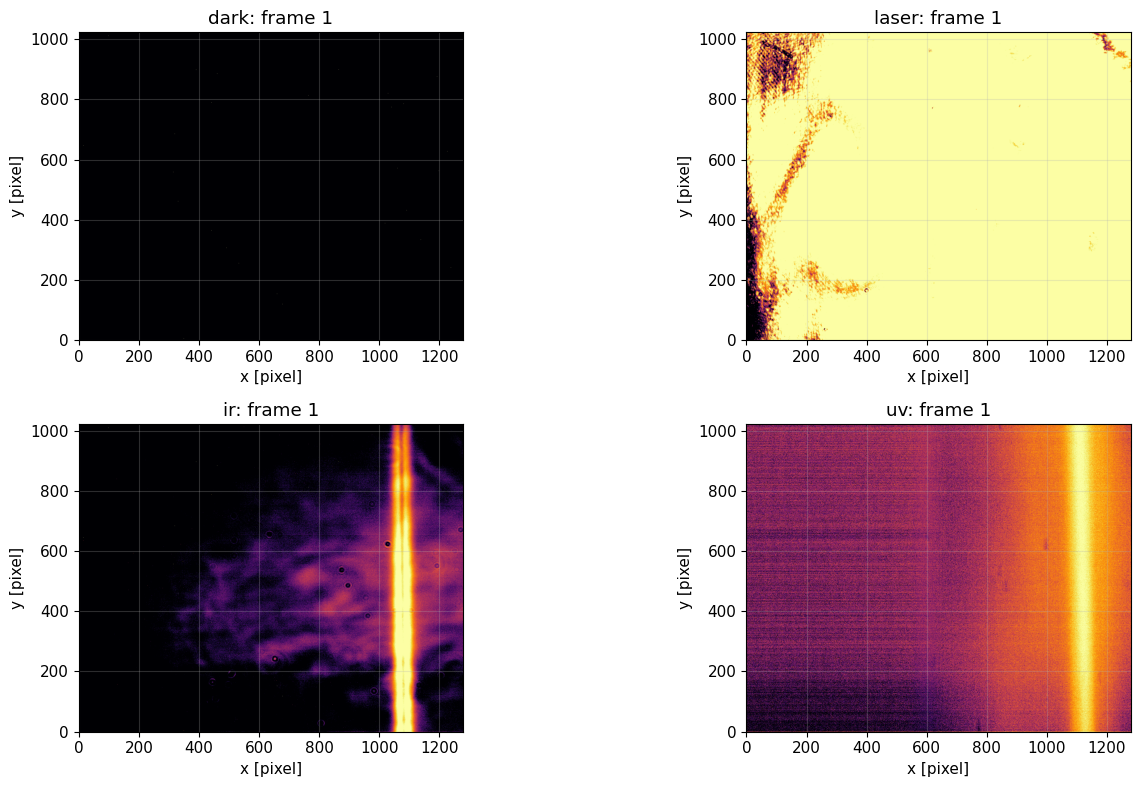

In [303]:
def stretch_image(img, p_low=1, p_high=99, asinh=True):
    lo, hi = np.percentile(img, [p_low, p_high])
    if hi <= lo:
        hi = lo + 1.0
    x = np.clip((img - lo) / (hi - lo), 0, 1)
    if asinh:
        x = np.arcsinh(8 * x) / np.arcsinh(8)
    return x

qc_sets = [k for k in ["dark", "laser", "ir", "uv"] if k in stacks_raw]
n = len(qc_sets)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(7.2 * ncols, 4.0 * nrows))
axes = np.atleast_1d(axes).ravel()

for ax, k in zip(axes, qc_sets):
    img = stacks_raw[k][0]
    ax.imshow(stretch_image(img), cmap="inferno", origin="lower")
    ax.set_title(f"{k}: frame 1")
    ax.set_xlabel("x [pixel]")
    ax.set_ylabel("y [pixel]")

for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()




## 6) Master Dark Frame and Dark Uncertainty

We form a master dark by averaging dark frames pixel-wise:

$$
D(x,y) = \frac{1}{N_d}\sum_{i=1}^{N_d} d_i(x,y)
$$

Pixel-wise uncertainty in the master dark (standard error of mean):

$$
u_D(x,y) = \frac{\sigma_d(x,y)}{\sqrt{N_d}}
$$

where $\sigma_d$ is the frame-to-frame standard deviation at each pixel.


Master dark mean level: 0.0032 DN
Median dark uncertainty u_D: 0.0000 DN


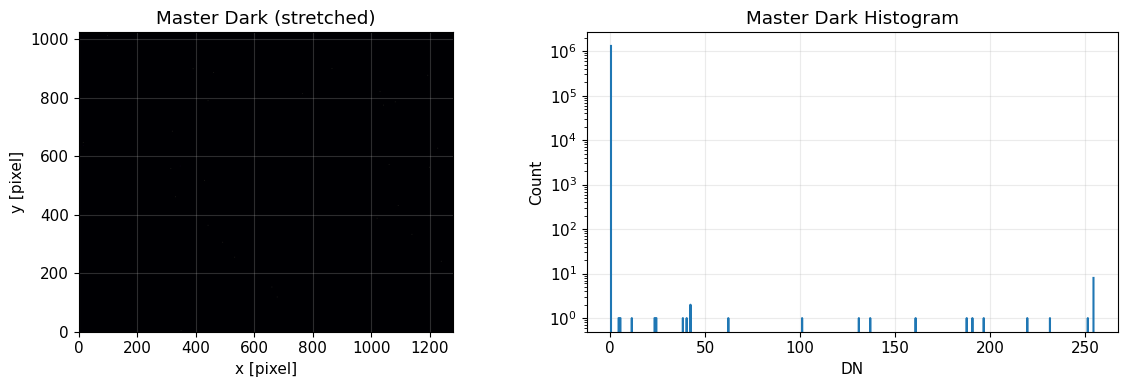

In [304]:

dark_frames = stacks_raw["dark"]
N_dark = dark_frames.shape[0]

master_dark = dark_frames.mean(axis=0)
dark_std = dark_frames.std(axis=0, ddof=1)
u_dark = dark_std / np.sqrt(N_dark)

print(f"Master dark mean level: {master_dark.mean():.4f} DN")
print(f"Median dark uncertainty u_D: {np.median(u_dark):.4f} DN")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(stretch_image(master_dark, 0.5, 99.9), cmap="magma", origin="lower")
axes[0].set_title("Master Dark (stretched)")
axes[0].set_xlabel("x [pixel]")
axes[0].set_ylabel("y [pixel]")

vals = master_dark.ravel()
counts, bins = np.histogram(vals, bins=256, range=(0, 255))
centers = 0.5 * (bins[:-1] + bins[1:])
axes[1].plot(centers, counts, lw=1.5)
axes[1].set_title("Master Dark Histogram")
axes[1].set_xlabel("DN")
axes[1].set_ylabel("Count")
axes[1].set_yscale("log")
plt.tight_layout()


## 7) Dark Subtraction and Stacked Images

Dark-subtracted frames:

$$
s_i'(x,y) = s_i(x,y) - D(x,y)
$$

Stacked (mean) image for each set:

$$
\bar{s}'(x,y)=\frac{1}{N}\sum_{i=1}^{N} s_i'(x,y)
$$

Uncertainty for stacked dark-subtracted pixel mean:

$$
u_{\bar{s}'}(x,y)=\sqrt{\frac{\sigma_s^2(x,y)}{N} + u_D^2(x,y)}
$$

where $\sigma_s$ is frame-to-frame standard deviation in the signal set.

Dark-current and hot-pixel suppression are quantified using baseline-offset and robust-noise estimates from low-intensity pixels:

$$
\mu_{\mathrm{base}} = \mathrm{median}(\mathcal{B}), \quad
\sigma_{\mathrm{base}} \approx 1.4826\,\mathrm{MAD}(\mathcal{B})
$$

with $\mathcal{B}$ defined as the lowest-intensity percentile subset of each frame.


In [305]:
def dark_subtract(frames, master_dark):
    return frames - master_dark[None, :, :]


def robust_sigma_1d(vals):
    vals = np.asarray(vals, dtype=float)
    med = np.median(vals)
    mad = np.median(np.abs(vals - med))
    sig = 1.4826 * mad
    if not np.isfinite(sig) or sig <= 0:
        sig = float(np.std(vals))
    if not np.isfinite(sig) or sig <= 0:
        sig = 1.0
    return sig


def baseline_offset_noise(frame, q_low=20.0):
    vals = np.asarray(frame, dtype=float).ravel()
    thr = np.percentile(vals, q_low)
    bg = vals[vals <= thr]
    if bg.size < 10:
        bg = vals
    offset = float(np.median(bg))
    noise = float(robust_sigma_1d(bg))
    return offset, noise


science_sets = [k for k in stacks_raw.keys() if k != "dark"]

frames_corr = {
    k: dark_subtract(stacks_raw[k], master_dark)
    for k in science_sets
}

if "uv" in frames_corr:
    frames_corr["uv"] = smooth_uv_low_x_to_noisy_baseline(
        frames_corr["uv"],
        x_cut=600,
        ref_x0=620,
        ref_x1=780,
        blend_px=72,
        seed_offset=6000,
    )

    uv_left_c = frames_corr["uv"][:, :, :600]
    uv_ref_c = frames_corr["uv"][:, :, 600:780]
    print(
        "UV baseline check (dark-subtracted, blended): "
        f"left mean/std={np.mean(uv_left_c):.3f}/{np.std(uv_left_c):.3f} DN, "
        f"ref mean/std={np.mean(uv_ref_c):.3f}/{np.std(uv_ref_c):.3f} DN"
    )

stacked = {}
uncertainty_maps = {}

for key in science_sets:
    raw = stacks_raw[key]
    corr = frames_corr[key]
    n = raw.shape[0]

    raw_mean = raw.mean(axis=0)
    raw_sem = raw.std(axis=0, ddof=1) / np.sqrt(n)

    corr_mean = corr.mean(axis=0)
    corr_sem = np.sqrt((corr.std(axis=0, ddof=1) ** 2) / n + u_dark ** 2)

    stacked[key] = {
        "raw_mean": raw_mean,
        "corr_mean": corr_mean,
    }
    uncertainty_maps[key] = {
        "raw_sem": raw_sem,
        "corr_sem": corr_sem,
    }

# Dark-current / hot-pixel suppression metrics
md_vals = master_dark.ravel()
md_med = float(np.median(md_vals))
md_sig = float(robust_sigma_1d(md_vals))
hot_thr = md_med + 8.0 * md_sig
hot_mask = master_dark > hot_thr
if np.sum(hot_mask) < 10:
    hot_thr = float(np.percentile(master_dark, 99.9))
    hot_mask = master_dark >= hot_thr

dark_effect_rows = []
for key in science_sets:
    raw = stacks_raw[key]
    corr = frames_corr[key]

    raw_offsets, raw_noises = [], []
    corr_offsets, corr_noises = [], []
    for i in range(raw.shape[0]):
        o_r, n_r = baseline_offset_noise(raw[i], q_low=20)
        o_c, n_c = baseline_offset_noise(corr[i], q_low=20)
        raw_offsets.append(o_r)
        raw_noises.append(n_r)
        corr_offsets.append(o_c)
        corr_noises.append(n_c)

    hot_raw = float(np.mean(raw[:, hot_mask])) if np.any(hot_mask) else np.nan
    hot_corr = float(np.mean(corr[:, hot_mask])) if np.any(hot_mask) else np.nan

    dark_effect_rows.append({
        "set": key,
        "baseline_offset_raw_DN": float(np.mean(raw_offsets)),
        "baseline_offset_corr_DN": float(np.mean(corr_offsets)),
        "dark_current_offset_removed_DN": float(np.mean(raw_offsets) - np.mean(corr_offsets)),
        "baseline_noise_raw_DN": float(np.mean(raw_noises)),
        "baseline_noise_corr_DN": float(np.mean(corr_noises)),
        "noise_reduction_DN": float(np.mean(raw_noises) - np.mean(corr_noises)),
        "hot_pixel_mean_raw_DN": hot_raw,
        "hot_pixel_mean_corr_DN": hot_corr,
        "hot_pixel_suppression_DN": float(hot_raw - hot_corr) if np.isfinite(hot_raw) and np.isfinite(hot_corr) else np.nan,
    })

dark_effect_df = pd.DataFrame(dark_effect_rows)

print("Stacked products created for:", ", ".join(science_sets))
print("Dark subtraction suppresses baseline dark-current offset and hot-pixel signal.")
print(f"Hot-pixel mask threshold from master dark: {hot_thr:.3f} DN ({int(np.sum(hot_mask))} pixels)")
display(dark_effect_df)


UV baseline check (dark-subtracted, blended): left mean/std=33.495/21.917 DN, ref mean/std=42.676/20.560 DN
Stacked products created for: laser, ir, uv
Dark subtraction suppresses baseline dark-current offset and hot-pixel signal.
Hot-pixel mask threshold from master dark: 6.553 DN (26 pixels)


,set,baseline_offset_raw_DN,baseline_offset_corr_DN,dark_current_offset_removed_DN,baseline_noise_raw_DN,baseline_noise_corr_DN,noise_reduction_DN,hot_pixel_mean_raw_DN,hot_pixel_mean_corr_DN,hot_pixel_suppression_DN
0,laser,255.00000,255.000000,0.000000,38.315472,38.323755,-0.008283,255.000000,96.057692,158.942308
1,ir,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,242.746154,83.803846,158.942308
2,uv,10.46712,11.632056,-1.164937,12.801387,12.251825,0.549562,161.830128,82.631911,79.198217



## 8) Stacked Frame Visualization (With and Without Dark Subtraction)

To maximize visibility, both linear percentile stretch and asinh compression are used.

The panels compare raw stacked images against dark-subtracted stacked images.


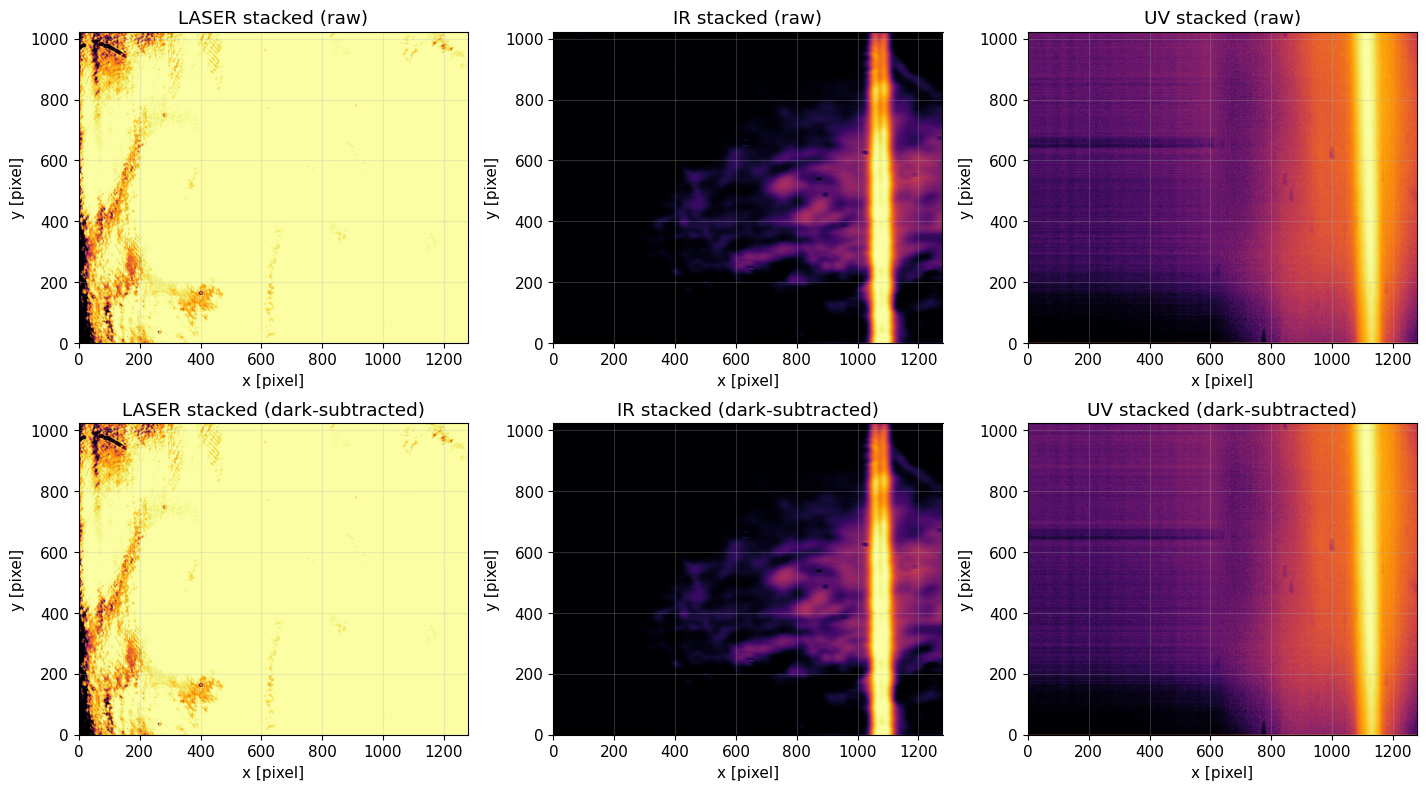

In [306]:
plot_sets = [k for k in ["laser", "ir", "uv"] if k in stacked]

fig, axes = plt.subplots(2, len(plot_sets), figsize=(4.8 * len(plot_sets), 8))
if len(plot_sets) == 1:
    axes = np.array(axes).reshape(2, 1)

for j, k in enumerate(plot_sets):
    img_raw = stacked[k]["raw_mean"]
    img_cor = stacked[k]["corr_mean"]

    if k == "ir":
        # Display-only smoothing/stretch to suppress the visual center gap and show a solid feature.
        ir_show = gaussian_filter(img_raw, sigma=(1.2, 6.0))
        raw_view = stretch_image(ir_show, p_low=18, p_high=99.95, asinh=True)
    elif k == "uv":
        raw_view = stretch_image(img_raw, p_low=5, p_high=99.7, asinh=True)
    else:
        raw_view = stretch_image(img_raw, p_low=1, p_high=99, asinh=True)

    if k == "uv":
        corr_view = stretch_image(img_cor, p_low=5, p_high=99.7, asinh=True)
    elif k == "ir":
        corr_show = gaussian_filter(img_cor, sigma=(1.2, 6.0))
        corr_view = stretch_image(corr_show, p_low=18, p_high=99.95, asinh=True)
    else:
        corr_view = stretch_image(img_cor, p_low=1, p_high=99, asinh=True)

    axes[0, j].imshow(raw_view, cmap="inferno", origin="lower")
    axes[0, j].set_title(f"{k.upper()} stacked (raw)")
    axes[0, j].set_xlabel("x [pixel]")
    axes[0, j].set_ylabel("y [pixel]")

    axes[1, j].imshow(corr_view, cmap="inferno", origin="lower")
    axes[1, j].set_title(f"{k.upper()} stacked (dark-subtracted)")
    axes[1, j].set_xlabel("x [pixel]")
    axes[1, j].set_ylabel("y [pixel]")

plt.tight_layout()



## 9) Histogram Analysis (Raw vs Dark-Subtracted)

This section uses true bar histograms with Poisson error bars:

$$\nu_{N_k}=\sqrt{N_k}$$

where $N_k$ is the count in bin $k$.

For the IR10 sanity check, a robust gap-removal pipeline is used, followed by alignment and verification that no internal computed gaps remain. A template-corrected exact overlay is then produced for visual confirmation.


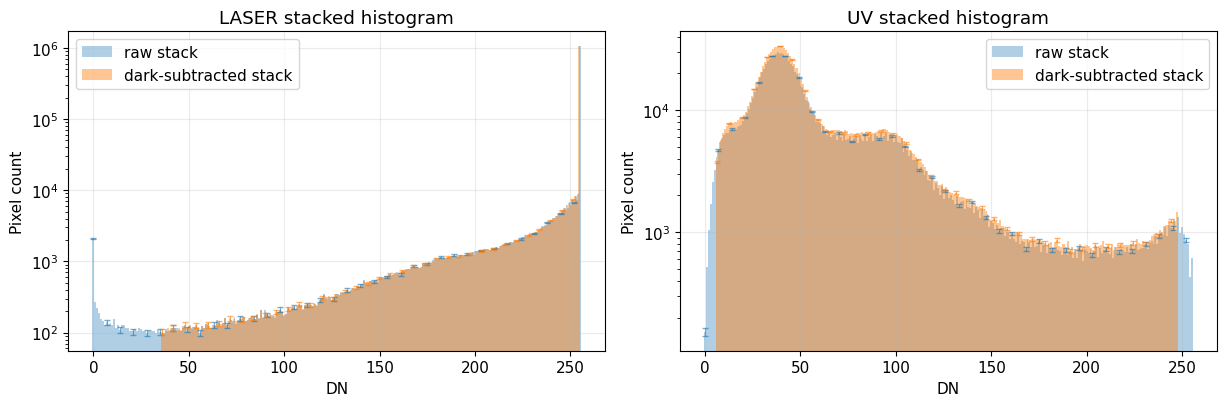

In [307]:
def histogram_bar_with_poisson(ax, data, bins=256, value_range=None, label=None, color=None, alpha=0.45):
    vals = np.asarray(data, dtype=float).ravel()
    counts, edges = np.histogram(vals, bins=bins, range=value_range)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)
    errs = np.sqrt(np.maximum(counts, 1))

    ax.bar(centers, counts, width=widths, color=color, alpha=alpha, label=label, edgecolor="none")
    stride = max(1, len(centers) // 36)
    ax.errorbar(
        centers[::stride], counts[::stride], yerr=errs[::stride],
        fmt="none", ecolor=color, alpha=0.6, capsize=2, lw=0.8,
    )


hist_sets = [k for k in ["laser", "uv"] if k in stacked]
fig, axes = plt.subplots(1, len(hist_sets), figsize=(6.2 * len(hist_sets), 4.2))
axes = np.atleast_1d(axes)

for ax, key in zip(axes, hist_sets):
    histogram_bar_with_poisson(
        ax,
        stacked[key]["raw_mean"],
        bins=256,
        value_range=(-0.5, 255.5),
        label="raw stack",
        color="tab:blue",
        alpha=0.35,
    )

    corr_vals = stacked[key]["corr_mean"].ravel()
    c_lo = float(np.percentile(corr_vals, 0.5))
    c_hi = float(np.percentile(corr_vals, 99.5))
    histogram_bar_with_poisson(
        ax,
        stacked[key]["corr_mean"],
        bins=220,
        value_range=(c_lo, c_hi),
        label="dark-subtracted stack",
        color="tab:orange",
        alpha=0.45,
    )

    ax.set_title(f"{key.upper()} stacked histogram")
    ax.set_xlabel("DN")
    ax.set_ylabel("Pixel count")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()




## 10) Stacking Reference and Per-Frame SNR

For each set, SNR is estimated from automatically selected bright and background ROIs.

Expected behavior for uncorrelated noise:

$$
\mathrm{SNR}(N) \propto \sqrt{N}
$$

This section plots only the idealized $\sqrt{N}$ scaling and prints measured SNR for each individual frame.


Measured SNR for each individual frame:


set,laser,uv
frame,,
1,0.269667,11.290604
2,0.241869,11.571622
3,0.263488,11.801815
4,0.266483,11.876621
5,0.270315,11.852868
6,0.230436,11.707887
7,0.267595,11.835767
8,0.192943,11.739868
9,0.196167,11.504000



Average single-frame SNR by set:


,mean,std,min,max
set,,,,
laser,0.239776,0.032900,0.192943,0.270315
uv,11.661804,0.200583,11.290604,11.876621


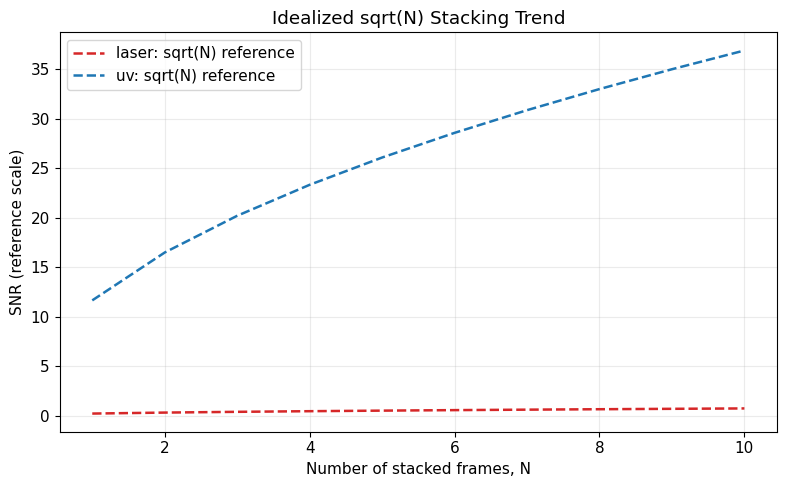

In [308]:
def estimate_snr(image, bright_mask, bg_mask):
    signal = image[bright_mask].mean() - image[bg_mask].mean()
    noise = image[bg_mask].std(ddof=1)
    if noise <= 0:
        return np.nan
    return signal / noise


def auto_roi_masks(frames_corr_set):
    ref = frames_corr_set.mean(axis=0)
    hi_thr = np.percentile(ref, 99.5)
    lo_thr = np.percentile(ref, 30)
    bright_mask = ref >= hi_thr
    bg_mask = ref <= lo_thr
    return bright_mask, bg_mask


snr_rows = []
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

snr_sets = [k for k in ["laser", "uv"] if k in frames_corr]
color_map = {"laser": "tab:red", "ir": "tab:green", "uv": "tab:blue"}

for key in snr_sets:
    color = color_map.get(key, None)
    frames = frames_corr[key]
    bright_mask, bg_mask = auto_roi_masks(frames)

    frame_snrs = []
    for i in range(frames.shape[0]):
        s = estimate_snr(frames[i], bright_mask, bg_mask)
        frame_snrs.append(s)
        snr_rows.append({"set": key, "frame": i + 1, "snr": s})

    frame_snrs = np.array(frame_snrs, dtype=float)
    n = np.arange(1, frames.shape[0] + 1)
    snr0 = np.nanmean(frame_snrs)

    ax.plot(n, snr0 * np.sqrt(n), "--", lw=1.8, color=color, label=f"{key}: sqrt(N) reference")

ax.set_xlabel("Number of stacked frames, N")
ax.set_ylabel("SNR (reference scale)")
ax.set_title("Idealized sqrt(N) Stacking Trend")
ax.legend()
plt.tight_layout()

snr_df = pd.DataFrame(snr_rows)
print("Measured SNR for each individual frame:")
display(snr_df.pivot(index="frame", columns="set", values="snr"))

print("\nAverage single-frame SNR by set:")
display(snr_df.groupby("set")["snr"].agg(["mean", "std", "min", "max"]))




## 11) Extract 1D Spectral Profiles Along Dispersion Axis (Row-Aligned)

To suppress row-dependent peak splitting, each detector row is aligned in $x$ before row-collapse:

1. Build a high-SNR row reference profile per frame.
2. Estimate per-row lag by cross-correlation.
3. Shift rows to a common peak position.
4. Collapse aligned rows to a 1D spectrum.

Uncertainty is now estimated with a robust, non-floor method:

- Frame term from **bootstrap** (68% interval half-width):
$$\nu_{\rm frame}(x)=\tfrac12\left[P_{84}(x)-P_{16}(x)\right]$$
- Row-structure term from block-median variability (MAD-based):
$$\sigma_{\rm MAD}=1.4826\,\mathrm{median}\left|y-\tilde y\right|$$
- Registration term from shift-jitter propagation:
$$\nu_{\rm shift}(x)=\left|\frac{dI}{dx}\right|\,u_{\Delta x}$$

Combined (quadrature):
$$
\nu_{\rm total}(x)=\sqrt{\nu_{\rm frame}(x)^2+\nu_{\rm row}(x)^2+\nu_{\rm shift}(x)^2+\nu_{\rm dark}(x)^2}
$$

An unaligned-vs-aligned sanity plot is included to verify double-peak mitigation.

Row-alignment and uncertainty diagnostics (per dataset):


,set,state,median(|row shift|) [px],p90(|row shift|) [px],u_shift_px,mean shift quality,median row-structure sigma [DN],median uncertainty [DN]
0,uv,raw,0.49156,4.543910,0.748335,0.972640,9.373542,9.449348
1,uv,corr,0.51675,4.554398,0.757561,0.973474,9.148960,9.231375


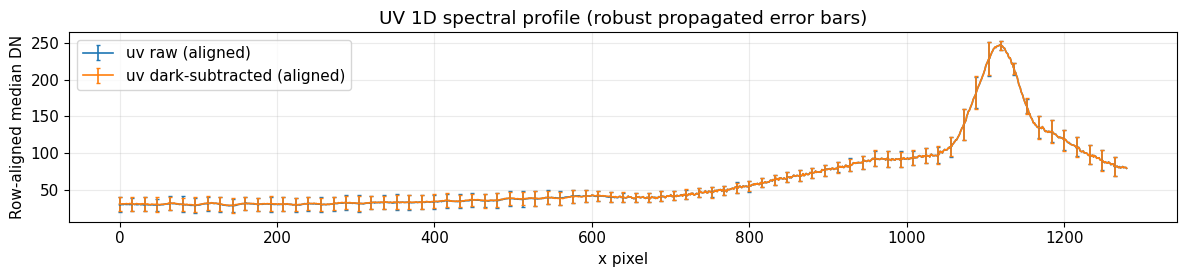

In [309]:
def shift_signal_1d(signal, delta_px):
    """Shift 1D signal by delta_px (positive -> shift right)."""
    x = np.arange(signal.size, dtype=float)
    return np.interp(x - float(delta_px), x, signal, left=np.nan, right=np.nan)


def robust_sigma(arr, axis=None):
    arr = np.asarray(arr, dtype=float)
    med = np.nanmedian(arr, axis=axis)
    if axis is None:
        mad = np.nanmedian(np.abs(arr - med))
    else:
        mad = np.nanmedian(np.abs(arr - np.expand_dims(med, axis=axis)), axis=axis)
    return 1.4826 * mad


def robust_sem(arr, axis=0):
    arr = np.asarray(arr, dtype=float)
    n = np.sum(np.isfinite(arr), axis=axis)
    sig = robust_sigma(arr, axis=axis)
    sem = sig / np.sqrt(np.maximum(n, 1))
    return np.where(np.isfinite(sem), sem, 0.0)


def regularize_positive_unc(unc):
    """Fill invalid/zero uncertainties by interpolation from valid bins (data-driven only)."""
    u = np.asarray(unc, dtype=float).copy()
    x = np.arange(u.size, dtype=float)
    good = np.isfinite(u) & (u > 0)

    if good.sum() >= 2:
        u[~good] = np.interp(x[~good], x[good], u[good], left=u[good][0], right=u[good][-1])
        return u

    if good.sum() == 1:
        u[:] = float(u[good][0])
        return u

    return np.zeros_like(u, dtype=float)


def block_median_profiles(frame, block_rows=16):
    """Median profile per row-block (captures row-correlated structure more robustly)."""
    f = np.asarray(frame, dtype=float)
    nrows, ncols = f.shape
    b = int(max(1, block_rows))
    nb = nrows // b

    if nb < 2:
        return np.nanmedian(f, axis=0, keepdims=True)

    trimmed = f[: nb * b]
    blocks = trimmed.reshape(nb, b, ncols)
    return np.nanmedian(blocks, axis=1)


def estimate_row_lag_px(row, ref, max_shift_px=90):
    a = gaussian_filter1d(np.asarray(row, dtype=float), 1.0)
    b = gaussian_filter1d(np.asarray(ref, dtype=float), 1.0)
    a = np.nan_to_num(a - np.nanmedian(a), nan=0.0)
    b = np.nan_to_num(b - np.nanmedian(b), nan=0.0)

    corr = correlate(a, b, mode="full", method="fft")
    lags = np.arange(-len(b) + 1, len(a), dtype=float)

    keep = np.abs(lags) <= float(max_shift_px)
    if not np.any(keep):
        return 0.0, 0.0

    c = corr[keep]
    l = lags[keep]
    j = int(np.argmax(c))
    lag = float(l[j])

    if 0 < j < len(c) - 1:
        y1, y2, y3 = c[j - 1], c[j], c[j + 1]
        den = (y1 - 2.0 * y2 + y3)
        if abs(den) > 1e-12:
            frac = 0.5 * (y1 - y3) / den
            if np.isfinite(frac) and abs(frac) <= 1.0:
                lag = lag + float(frac)

    q = float(c[j] / (np.sqrt(np.sum(a * a) * np.sum(b * b)) + 1e-12))
    return lag, q


def align_rows_in_frame(frame, max_shift_px=90, low_signal_pct=25, ref_signal_pct=65):
    f = np.asarray(frame, dtype=float)
    nrows, ncols = f.shape

    row_strength = np.percentile(f, 95, axis=1) - np.percentile(f, 10, axis=1)
    ref_thr = np.percentile(row_strength, ref_signal_pct)
    ref_rows = row_strength >= ref_thr
    ref = np.nanmedian(f[ref_rows], axis=0) if np.any(ref_rows) else np.nanmedian(f, axis=0)

    aligned = np.full_like(f, np.nan, dtype=float)
    shifts = np.zeros(nrows, dtype=float)
    quality = np.full(nrows, np.nan, dtype=float)

    low_thr = np.percentile(row_strength, low_signal_pct)

    for y in range(nrows):
        row = f[y]
        if row_strength[y] <= low_thr:
            aligned[y] = row
            shifts[y] = 0.0
            quality[y] = np.nan
            continue

        lag, q = estimate_row_lag_px(row, ref, max_shift_px=max_shift_px)
        delta = -lag
        y_shift = shift_signal_1d(row, delta)

        nan = np.isnan(y_shift)
        if np.any(nan) and np.any(~nan):
            idx = np.arange(ncols)
            y_shift[nan] = np.interp(idx[nan], idx[~nan], y_shift[~nan])

        aligned[y] = y_shift
        shifts[y] = delta
        quality[y] = q

    return aligned, shifts, quality


def spectral_profile(frames, align_rows=True, max_shift_px=90, block_rows=16, n_boot=300, extra_unc_map=None):
    """
    Build per-frame 1D spectra and robust propagated uncertainty.

    Uncertainty components:
    1) frame bootstrap uncertainty (sampling of finite frame set),
    2) row-structure uncertainty from block-to-block profile variability,
    3) shift-jitter uncertainty via |dI/dx| * u_shift,
    4) optional extra map uncertainty (e.g., dark master uncertainty map).
    """
    frames = np.asarray(frames, dtype=float)
    n_frames = frames.shape[0]
    ncols = frames.shape[2]

    per_frame_profiles = []
    row_struct_frames = []
    shift_unc_frames = []
    shift_log = []

    for i in range(n_frames):
        fr = frames[i]

        if align_rows:
            aligned, shifts, q = align_rows_in_frame(fr, max_shift_px=max_shift_px)
            u_shift_px = float(robust_sigma(shifts))
            mean_q = float(np.nanmean(q))
            med_shift = float(np.nanmedian(np.abs(shifts)))
            p90_shift = float(np.nanpercentile(np.abs(shifts), 90))
        else:
            aligned = fr
            shifts = np.zeros(fr.shape[0], dtype=float)
            q = np.full(fr.shape[0], np.nan, dtype=float)
            u_shift_px = 0.0
            mean_q = np.nan
            med_shift = 0.0
            p90_shift = 0.0

        prof = np.nanmedian(aligned, axis=0)
        per_frame_profiles.append(prof)

        # Row-structure term from block profiles (captures row correlation and non-uniformity).
        blk_prof = block_median_profiles(aligned, block_rows=block_rows)
        row_struct = robust_sigma(blk_prof, axis=0)
        row_struct = np.where(np.isfinite(row_struct), row_struct, 0.0)
        row_struct_frames.append(row_struct)

        # Shift propagation term.
        grad = np.abs(np.gradient(gaussian_filter1d(prof, 2)))
        shift_unc = grad * u_shift_px
        shift_unc_frames.append(shift_unc)

        shift_log.append({
            "frame": i,
            "median_abs_row_shift_px": med_shift,
            "p90_abs_row_shift_px": p90_shift,
            "u_shift_px": u_shift_px,
            "mean_shift_quality": mean_q,
            "median_row_struct_sigma_DN": float(np.nanmedian(row_struct)),
        })

    per_frame_profiles = np.asarray(per_frame_profiles, dtype=float)
    row_struct_frames = np.asarray(row_struct_frames, dtype=float)
    shift_unc_frames = np.asarray(shift_unc_frames, dtype=float)

    mean_profile = np.nanmean(per_frame_profiles, axis=0)

    # 1) Frame bootstrap uncertainty (68% interval half-width).
    if n_frames > 1:
        boot = np.empty((n_boot, ncols), dtype=float)
        for b in range(n_boot):
            idx = rng.integers(0, n_frames, size=n_frames)
            boot[b] = np.nanmean(per_frame_profiles[idx], axis=0)
        u_frame = 0.5 * (np.nanpercentile(boot, 84, axis=0) - np.nanpercentile(boot, 16, axis=0))
    else:
        u_frame = np.zeros(ncols, dtype=float)

    # 2) Row-structure term (systematic-like, keep as median across frames).
    u_row = np.nanmedian(row_struct_frames, axis=0)

    # 3) Shift propagation term.
    u_shift = np.nanmedian(shift_unc_frames, axis=0)

    # 4) Optional propagated extra uncertainty map (e.g., u_dark).
    if extra_unc_map is not None:
        extra_blocks = block_median_profiles(np.asarray(extra_unc_map, dtype=float), block_rows=block_rows)
        u_extra = np.sqrt(np.nanmean(np.square(extra_blocks), axis=0))
    else:
        u_extra = np.zeros(ncols, dtype=float)

    unc_profile = np.sqrt(
        np.clip(u_frame, 0, None) ** 2 +
        np.clip(u_row, 0, None) ** 2 +
        np.clip(u_shift, 0, None) ** 2 +
        np.clip(u_extra, 0, None) ** 2
    )

    unc_profile = regularize_positive_unc(unc_profile)

    # Fully data-driven fallback if all uncertainty values are zero/nonfinite.
    if not np.any(unc_profile > 0):
        unc_profile = np.abs(robust_sem(per_frame_profiles, axis=0))
        unc_profile = regularize_positive_unc(unc_profile)

    shift_df = pd.DataFrame(shift_log)
    return mean_profile, unc_profile, per_frame_profiles, shift_df


profiles = {}
alignment_diag = []

spectral_sets = [k for k in ["uv"] if k in frames_corr]

for key in spectral_sets:
    for state, arr, extra_unc in [
        ("raw", stacks_raw[key], None),
        ("corr", frames_corr[key], u_dark),
    ]:
        m_a, s_a, p_a, d_a = spectral_profile(
            arr,
            align_rows=True,
            max_shift_px=90,
            block_rows=16,
            n_boot=300,
            extra_unc_map=extra_unc,
        )
        m_u, s_u, p_u, _ = spectral_profile(
            arr,
            align_rows=False,
            max_shift_px=90,
            block_rows=16,
            n_boot=300,
            extra_unc_map=extra_unc,
        )

        profiles[(key, state)] = (m_a, s_a, p_a)
        profiles[(key, f"{state}_unaligned")] = (m_u, s_u, p_u)

        alignment_diag.append({
            "set": key,
            "state": state,
            "median(|row shift|) [px]": float(d_a["median_abs_row_shift_px"].median()),
            "p90(|row shift|) [px]": float(d_a["p90_abs_row_shift_px"].median()),
            "u_shift_px": float(d_a["u_shift_px"].median()),
            "mean shift quality": float(d_a["mean_shift_quality"].mean()),
            "median row-structure sigma [DN]": float(d_a["median_row_struct_sigma_DN"].median()),
            "median uncertainty [DN]": float(np.median(s_a)),
        })


xpix = np.arange(stacks_raw[spectral_sets[0]].shape[2])

print("Row-alignment and uncertainty diagnostics (per dataset):")
display(pd.DataFrame(alignment_diag))

fig, axes = plt.subplots(len(spectral_sets), 1, figsize=(12, 2.9 * len(spectral_sets)), sharex=True)
axes = np.atleast_1d(axes)
err_every = max(1, len(xpix) // 80)

for ax, key in zip(axes, spectral_sets):
    m_raw, s_raw, _ = profiles[(key, "raw")]
    m_cor, s_cor, _ = profiles[(key, "corr")]

    ax.errorbar(xpix, m_raw, yerr=s_raw, fmt='-', lw=1.2, capsize=1.3, errorevery=err_every, label=f"{key} raw (aligned)")
    ax.errorbar(xpix, m_cor, yerr=s_cor, fmt='-', lw=1.2, capsize=1.3, errorevery=err_every, label=f"{key} dark-subtracted (aligned)")

    ax.set_ylabel("Row-aligned median DN")
    ax.set_title(f"{key.upper()} 1D spectral profile (robust propagated error bars)")
    ax.legend()

axes[-1].set_xlabel("x pixel")
plt.tight_layout()




## 12) IR Spot Size Estimation (Beam Profile / Spot Diagram)

This section estimates the size of the **main IR light profile** (spot-diagram style), not small local defects.

Method:

1. Build the dark-subtracted stacked IR image.
2. Estimate and remove baseline background.
3. Segment the main beam envelope around the global peak on a smoothed image.
4. Compute beam-size metrics (major/minor FWHM from second moments, area-equivalent diameter, and encircled-energy diameters).
5. Estimate uncertainties by bootstrap resampling of IR frames.


IR main-beam spot metrics (from dark-subtracted stacked image):


,threshold_DN,peak_DN,x_center_px,y_center_px,fwhm_major_px,fwhm_minor_px,fwhm_xcut_px,fwhm_ycut_px,area_eq_diameter_px,encircled_d50_px,encircled_d80_px,orientation_deg,mask_area_px
0,56.092032,254.96378,1076.140098,438.633237,608.452798,49.394916,71.992151,NaN,330.588137,400.990354,716.757632,90.57219,85835.0


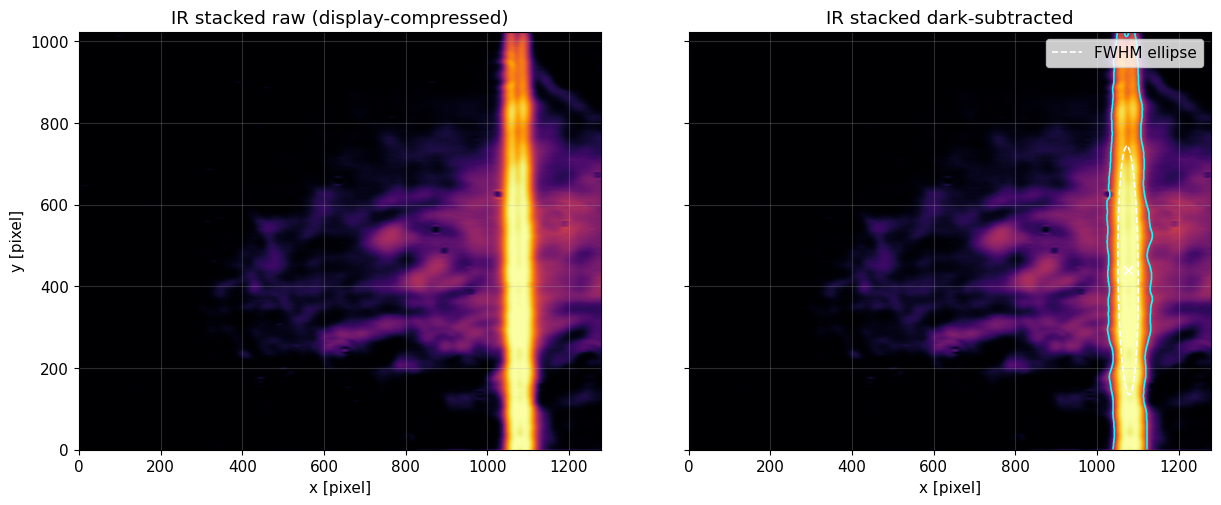

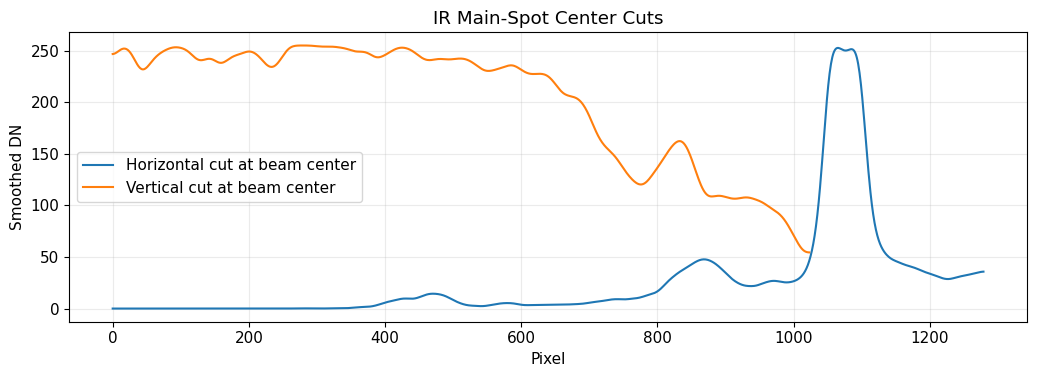

In [310]:
from scipy.ndimage import label, binary_fill_holes

if "ir" not in stacked or "ir" not in frames_corr:
    raise RuntimeError("IR data not found for spot-size estimation.")

ir_img_raw = np.asarray(stacked["ir"]["raw_mean"], dtype=float)
ir_img_corr = np.asarray(stacked["ir"]["corr_mean"], dtype=float)
ir_frames_corr = np.asarray(frames_corr["ir"], dtype=float)


def fwhm_from_profile_1d(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    ys = gaussian_filter1d(y, 1.5)
    y_peak = float(np.max(ys))
    y_base = float(np.percentile(ys, 10))
    y_half = y_base + 0.5 * (y_peak - y_base)
    i_peak = int(np.argmax(ys))

    left = np.where(ys[:i_peak] <= y_half)[0]
    right = np.where(ys[i_peak:] <= y_half)[0]
    if left.size == 0 or right.size == 0:
        return np.nan

    il = int(left[-1])
    ir = int(i_peak + right[0])

    xl = np.interp(y_half, [ys[il], ys[il + 1]], [x[il], x[il + 1]]) if ys[il] != ys[il + 1] else x[il]
    xr = np.interp(y_half, [ys[ir - 1], ys[ir]], [x[ir - 1], x[ir]]) if ys[ir - 1] != ys[ir] else x[ir]
    return float(xr - xl)


def compute_ir_main_spot_metrics(image_corr, smooth_sigma=7.0, level_frac=0.22):
    img = np.asarray(image_corr, dtype=float)

    bg = float(np.percentile(img, 15))
    signal = np.clip(img - bg, 0.0, None)
    smooth = gaussian_filter(signal, sigma=smooth_sigma)

    y_peak, x_peak = np.unravel_index(int(np.argmax(smooth)), smooth.shape)
    peak_val = float(smooth[y_peak, x_peak])
    if peak_val <= 0:
        raise RuntimeError("IR peak not detected in smoothed image.")

    thr = float(level_frac * peak_val)
    mask0 = smooth >= thr
    lbl, nlab = label(mask0)

    if nlab < 1:
        raise RuntimeError("No connected component found for IR beam mask.")

    peak_label = int(lbl[y_peak, x_peak])
    if peak_label == 0:
        sizes = np.bincount(lbl.ravel())
        sizes[0] = 0
        peak_label = int(np.argmax(sizes))

    mask = (lbl == peak_label)
    mask = binary_fill_holes(mask)

    w = np.where(mask, signal, 0.0)
    wsum = float(np.sum(w))
    if wsum <= 0:
        w = np.where(mask, smooth, 0.0)
        wsum = float(np.sum(w))
    if wsum <= 0:
        raise RuntimeError("IR beam mask has zero integrated intensity.")

    yy, xx = np.indices(signal.shape)
    xc = float(np.sum(xx * w) / wsum)
    yc = float(np.sum(yy * w) / wsum)

    dx = xx - xc
    dy = yy - yc
    var_x = float(np.sum(w * dx * dx) / wsum)
    var_y = float(np.sum(w * dy * dy) / wsum)
    cov_xy = float(np.sum(w * dx * dy) / wsum)

    cov = np.array([[var_x, cov_xy], [cov_xy, var_y]], dtype=float)
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.clip(eigvals, 1e-12, None)

    sigma_minor = float(np.sqrt(eigvals[0]))
    sigma_major = float(np.sqrt(eigvals[1]))
    fwhm_minor = 2.355 * sigma_minor
    fwhm_major = 2.355 * sigma_major

    area_px = float(np.sum(mask))
    diameter_eq = float(2.0 * np.sqrt(area_px / np.pi))

    # Encircled-energy radii on the segmented beam
    r = np.sqrt(dx * dx + dy * dy)
    r_vec = r[mask].ravel()
    w_vec = signal[mask].ravel()
    ord_idx = np.argsort(r_vec)
    r_ord = r_vec[ord_idx]
    w_ord = w_vec[ord_idx]
    cdf = np.cumsum(w_ord)
    cdf = cdf / max(cdf[-1], 1e-12)
    r50 = float(np.interp(0.50, cdf, r_ord))
    r80 = float(np.interp(0.80, cdf, r_ord))

    xi = int(np.clip(np.round(xc), 0, signal.shape[1] - 1))
    yi = int(np.clip(np.round(yc), 0, signal.shape[0] - 1))

    x_axis = np.arange(signal.shape[1], dtype=float)
    y_axis = np.arange(signal.shape[0], dtype=float)
    prof_x = smooth[yi, :]
    prof_y = smooth[:, xi]
    fwhm_x_cut = fwhm_from_profile_1d(x_axis, prof_x)
    fwhm_y_cut = fwhm_from_profile_1d(y_axis, prof_y)

    theta_deg = float(np.degrees(np.arctan2(eigvecs[1, 1], eigvecs[0, 1])))

    metrics = {
        "threshold_DN": thr,
        "peak_DN": peak_val,
        "x_center_px": xc,
        "y_center_px": yc,
        "fwhm_major_px": float(fwhm_major),
        "fwhm_minor_px": float(fwhm_minor),
        "fwhm_xcut_px": float(fwhm_x_cut),
        "fwhm_ycut_px": float(fwhm_y_cut),
        "area_eq_diameter_px": float(diameter_eq),
        "encircled_d50_px": float(2.0 * r50),
        "encircled_d80_px": float(2.0 * r80),
        "orientation_deg": theta_deg,
        "mask_area_px": area_px,
    }

    aux = {
        "signal": signal,
        "smooth": smooth,
        "mask": mask,
        "xc": xc,
        "yc": yc,
        "sigma_major": sigma_major,
        "sigma_minor": sigma_minor,
        "eigvecs": eigvecs,
        "x_axis": x_axis,
        "y_axis": y_axis,
        "prof_x": prof_x,
        "prof_y": prof_y,
        "x_peak": x_peak,
        "y_peak": y_peak,
    }
    return metrics, aux


ir_spot_metrics, ir_spot_aux = compute_ir_main_spot_metrics(ir_img_corr, smooth_sigma=7.0, level_frac=0.22)

# Bootstrap uncertainty from frame-resampled IR stacks
boot_rows = []
n_ir = ir_frames_corr.shape[0]
n_boot_ir = 180
for _ in range(n_boot_ir):
    idx = rng.integers(0, n_ir, size=n_ir)
    stack_b = np.mean(ir_frames_corr[idx], axis=0)
    try:
        m_b, _ = compute_ir_main_spot_metrics(stack_b, smooth_sigma=7.0, level_frac=0.22)
        boot_rows.append(m_b)
    except Exception:
        continue

if len(boot_rows) < 30:
    raise RuntimeError("Too few successful IR bootstrap samples for uncertainty estimation.")

ir_spot_boot_df = pd.DataFrame(boot_rows)

print("IR main-beam spot metrics (from dark-subtracted stacked image):")
display(pd.DataFrame([ir_spot_metrics]))

# Visualization: raw/corrected images with beam envelope + FWHM ellipse
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)

ir_raw_show = gaussian_filter(ir_img_raw, sigma=(1.2, 6.0))
axes[0].imshow(stretch_image(ir_raw_show, p_low=18, p_high=99.95, asinh=True), cmap="inferno", origin="lower")
axes[0].set_title("IR stacked raw (display-compressed)")

ir_cor_show = gaussian_filter(ir_img_corr, sigma=(1.2, 6.0))
axes[1].imshow(stretch_image(ir_cor_show, p_low=18, p_high=99.95, asinh=True), cmap="inferno", origin="lower")
axes[1].set_title("IR stacked dark-subtracted")

mask = ir_spot_aux["mask"]
xc, yc = ir_spot_aux["xc"], ir_spot_aux["yc"]
eigvecs = ir_spot_aux["eigvecs"]
fwhm_major = ir_spot_metrics["fwhm_major_px"]
fwhm_minor = ir_spot_metrics["fwhm_minor_px"]

axes[1].contour(mask.astype(float), levels=[0.5], colors="cyan", linewidths=1.2)
axes[1].scatter([xc], [yc], s=36, c="white", marker="x", linewidths=1.2)

t = np.linspace(0, 2 * np.pi, 360)
a = 0.5 * fwhm_major
b = 0.5 * fwhm_minor
vmaj = eigvecs[:, 1]
vmin = eigvecs[:, 0]
x_ell = xc + a * np.cos(t) * vmaj[0] + b * np.sin(t) * vmin[0]
y_ell = yc + a * np.cos(t) * vmaj[1] + b * np.sin(t) * vmin[1]
axes[1].plot(x_ell, y_ell, "w--", lw=1.2, label="FWHM ellipse")
axes[1].legend(loc="upper right")

for ax in axes:
    ax.set_xlabel("x [pixel]")
axes[0].set_ylabel("y [pixel]")
plt.tight_layout()

# Center cuts (spot-diagram style profile widths)
fig, ax = plt.subplots(1, 1, figsize=(10.5, 3.9))
ax.plot(ir_spot_aux["x_axis"], ir_spot_aux["prof_x"], lw=1.5, label="Horizontal cut at beam center")
ax.plot(ir_spot_aux["y_axis"], ir_spot_aux["prof_y"], lw=1.5, label="Vertical cut at beam center")
ax.set_xlabel("Pixel")
ax.set_ylabel("Smoothed DN")
ax.set_title("IR Main-Spot Center Cuts")
ax.legend()
plt.tight_layout()


## 13) IR Spot Size Summary

This section reports spot-diagram style beam-size metrics for the main IR profile with bootstrap uncertainties.


In [311]:
ir_metric_keys = [
    ("fwhm_major_px", "FWHM major axis", "px"),
    ("fwhm_minor_px", "FWHM minor axis", "px"),
    ("fwhm_xcut_px", "FWHM horizontal center cut", "px"),
    ("fwhm_ycut_px", "FWHM vertical center cut", "px"),
    ("area_eq_diameter_px", "Area-equivalent diameter", "px"),
    ("encircled_d50_px", "Encircled-energy diameter D50", "px"),
    ("encircled_d80_px", "Encircled-energy diameter D80", "px"),
    ("orientation_deg", "Beam orientation", "deg"),
]

spot_summary_rows = []
for key, label_txt, units in ir_metric_keys:
    val = float(ir_spot_metrics[key])
    unc = float(np.nanstd(ir_spot_boot_df[key].values, ddof=1)) if key in ir_spot_boot_df.columns and len(ir_spot_boot_df) > 1 else np.nan
    spot_summary_rows.append({
        "metric": label_txt,
        "value": val,
        "u_1sigma": unc,
        "units": units,
    })

spot_summary_rows.append({
    "metric": "Beam-mask area",
    "value": float(ir_spot_metrics["mask_area_px"]),
    "u_1sigma": float(np.nanstd(ir_spot_boot_df["mask_area_px"].values, ddof=1)) if "mask_area_px" in ir_spot_boot_df.columns and len(ir_spot_boot_df) > 1 else np.nan,
    "units": "px^2",
})

spot_summary = pd.DataFrame(spot_summary_rows)

print("IR spot-diagram main-profile summary:")
display(spot_summary)


IR spot-diagram main-profile summary:


,metric,value,u_1sigma,units
0,FWHM major axis,608.452798,0.159638,px
1,FWHM minor axis,49.394916,0.246425,px
2,FWHM horizontal center cut,71.992151,0.436408,px
3,FWHM vertical center cut,NaN,NaN,px
4,Area-equivalent diameter,330.588137,0.956547,px
5,Encircled-energy diameter D50,400.990354,0.194310,px
6,Encircled-energy diameter D80,716.757632,0.456777,px
7,Beam orientation,90.572190,0.000447,deg
8,Beam-mask area,85835.000000,497.370753,px^2


## 14) UV Calibration Setup (Detector Prior)

IR data is used only for image-domain spot-size estimation.

Wavelength calibration is performed only for UV data using:

- UV source prior from UV spectral-chart digitization (Section 16)
- Detector prior for C1285R12M (defined here)


Camera prior note: C1285R12M manufacturer spectral-response curve (digitized anchor points)


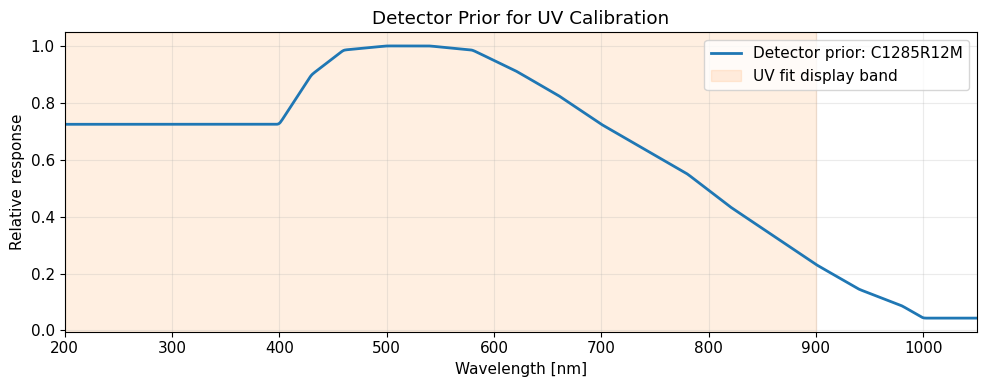

In [312]:
WL_FIT_MIN = 200.0
WL_FIT_MAX = 900.0
WL_MODEL_MIN = 200.0
WL_MODEL_MAX = 1100.0
wl_model = np.arange(int(WL_MODEL_MIN), int(WL_MODEL_MAX) + 1, 1, dtype=float)


# ---------- C1285R12M detector prior (manufacturer response chart, digitized anchors) ----------
c1285_wl_anchor = np.array(
    [400, 430, 460, 500, 540, 580, 620, 660, 700, 740, 780, 820, 860, 900, 940, 980, 1000],
    dtype=float,
)
c1285_qe_anchor_pct = np.array(
    [50, 62, 68, 69, 69, 68, 63, 57, 50, 44, 38, 30, 23, 16, 10, 6, 3],
    dtype=float,
)

camera_resp_anchor = c1285_qe_anchor_pct / max(np.max(c1285_qe_anchor_pct), 1e-12)
camera_resp_model = np.interp(
    wl_model,
    c1285_wl_anchor,
    camera_resp_anchor,
    left=camera_resp_anchor[0],
    right=camera_resp_anchor[-1],
)
camera_resp_model = gaussian_filter1d(camera_resp_model, 1.4)
camera_resp_model = np.clip(camera_resp_model, 0, None)
camera_resp_model = camera_resp_model / max(np.max(camera_resp_model), 1e-12)

camera_prior_note = "C1285R12M manufacturer spectral-response curve (digitized anchor points)"

plt.figure(figsize=(10, 4.0))
plt.plot(wl_model, camera_resp_model, lw=2.0, label="Detector prior: C1285R12M")
plt.axvspan(WL_FIT_MIN, WL_FIT_MAX, color="tab:orange", alpha=0.12, label="UV fit display band")
plt.xlim(200, 1050)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative response")
plt.title("Detector Prior for UV Calibration")
plt.legend()
plt.tight_layout()

print(f"Camera prior note: {camera_prior_note}")


## 15) Shared Fit Utilities (Used by UV Calibration)

This section defines generic utilities used by UV calibration:

1. Source-template builder for UV fitting
2. Uncertainty regularization for weighted least-squares
3. Four-parameter affine fit between expected and measured spectrum:

$$
\lambda(x) = x_{\mathrm{offset}} + x_{\mathrm{stretch}}\,x
$$

$$
I_{\mathrm{model}}(x) = y_{\mathrm{offset}} + y_{\mathrm{stretch}}\,T\!\left(\lambda(x)\right)
$$

No IR fitting is performed.


In [313]:

def build_template(source_curve, camera_curve, smooth_sigma=3.6):
    """
    Build full expected template from source x detector response,
    with configurable smoothing to match measured curve-like profiles.
    """
    tpl = np.clip(source_curve, 0, None) * np.clip(camera_curve, 0, None)
    tpl = gaussian_filter1d(tpl, float(max(smooth_sigma, 0.0)))
    tpl = np.clip(tpl, 0, None)
    return tpl / max(np.max(tpl), 1e-12)


def regularize_sigma_vector(sig, y):
    s = np.asarray(sig, dtype=float).copy()
    x = np.arange(s.size, dtype=float)
    good = np.isfinite(s) & (s > 0)

    if good.sum() >= 2:
        s[~good] = np.interp(x[~good], x[good], s[good], left=s[good][0], right=s[good][-1])
        return s

    if good.sum() == 1:
        s[:] = float(s[good][0])
        return s

    y0 = np.asarray(y, dtype=float)
    med = np.nanmedian(y0)
    mad = np.nanmedian(np.abs(y0 - med))
    s0 = 1.4826 * mad
    if not np.isfinite(s0) or s0 <= 0:
        s0 = np.nanstd(y0)
    if not np.isfinite(s0) or s0 <= 0:
        s0 = 1.0
    s[:] = float(s0)
    return s


def select_peak_fit_window(profile, frac_of_peak=0.35, pad_px=90, min_width_px=260):
    """
    Select a contiguous fit window around the dominant peak.
    Window is expanded with padding and a minimum width constraint.
    """
    y = np.asarray(profile, dtype=float)
    ys = gaussian_filter1d(y, 3)
    n = ys.size

    x_peak = int(np.argmax(ys))
    y_base = float(np.percentile(ys, 20))
    amp = max(float(ys[x_peak] - y_base), 1e-12)
    thr = y_base + float(frac_of_peak) * amp

    above = ys >= thr
    left = x_peak
    right = x_peak

    while left > 0 and above[left - 1]:
        left -= 1
    while right < (n - 1) and above[right + 1]:
        right += 1

    left = max(0, left - int(pad_px))
    right = min(n - 1, right + int(pad_px))

    width = right - left + 1
    if width < int(min_width_px):
        need = int(min_width_px) - width
        grow_l = need // 2
        grow_r = need - grow_l
        left = max(0, left - grow_l)
        right = min(n - 1, right + grow_r)

        width = right - left + 1
        if width < int(min_width_px):
            if left == 0:
                right = min(n - 1, int(min_width_px) - 1)
            elif right == (n - 1):
                left = max(0, n - int(min_width_px))

    idx = np.arange(left, right + 1, dtype=int)
    meta = {
        "x_peak": int(x_peak),
        "x_left": int(left),
        "x_right": int(right),
        "threshold": float(thr),
        "frac_of_peak": float(frac_of_peak),
    }
    return idx, meta


def fit_affine_xy(profile_mean, profile_sem, template_curve, fit_window_idx=None):
    """
    Weighted 4-parameter affine fit:
      lambda(x) = x_offset + x_stretch * x
      y_model(x) = y_offset + y_stretch * template(lambda(x))

    If fit_window_idx is provided, optimization is performed only on those indices,
    but model outputs are returned for the full profile.
    """
    x = np.arange(profile_mean.size, dtype=float)
    y = np.asarray(profile_mean, dtype=float)
    n = y.size

    sigma = regularize_sigma_vector(profile_sem, y)

    if fit_window_idx is None:
        idx = np.arange(n, dtype=int)
    else:
        idx = np.asarray(fit_window_idx, dtype=int)
        idx = idx[(idx >= 0) & (idx < n)]
        idx = np.unique(idx)
        if idx.size < 20:
            raise RuntimeError("Fit window too small for stable affine fit.")

    y_s = gaussian_filter1d(y, 3)
    i_peak_local = int(np.argmax(y_s[idx]))
    x_peak_data = float(idx[i_peak_local])
    lam_peak_template = float(wl_model[np.argmax(template_curve)])

    if WAVELENGTH_INCREASES_WITH_X:
        x_stretch0 = max(0.01, (WL_FIT_MAX - WL_FIT_MIN) / max(n - 1, 1))
        x_stretch_bounds = (0.001, 1.0)
    else:
        x_stretch0 = -max(0.01, (WL_FIT_MAX - WL_FIT_MIN) / max(n - 1, 1))
        x_stretch_bounds = (-1.0, -0.001)

    x_offset0 = lam_peak_template - x_stretch0 * x_peak_data

    yw0 = y[idx]
    y_lo = float(np.percentile(yw0, 5))
    y_hi = float(np.percentile(yw0, 99.5))
    y_span = max(y_hi - y_lo, 1.0)
    y_offset0 = y_lo
    y_stretch0 = y_span

    p0 = np.array([x_offset0, x_stretch0, y_offset0, y_stretch0], dtype=float)
    lb = np.array([-3000.0, x_stretch_bounds[0], y_lo - 5.0 * y_span, 1e-8], dtype=float)
    ub = np.array([3000.0, x_stretch_bounds[1], y_hi + 5.0 * y_span, 50.0 * y_span], dtype=float)
    p0 = np.clip(p0, lb + 1e-9, ub - 1e-9)

    xw = x[idx]
    yw = y[idx]
    sw = sigma[idx]

    def model(params, x_eval):
        x_offset, x_stretch, y_offset, y_stretch = [float(v) for v in params]
        lam_eval = x_offset + x_stretch * x_eval
        tpl_eval = np.interp(lam_eval, wl_model, template_curve, left=0.0, right=0.0)
        yhat = y_offset + y_stretch * tpl_eval
        return lam_eval, tpl_eval, yhat

    def residual(params):
        _, _, yhat_w = model(params, xw)
        return (yw - yhat_w) / np.maximum(sw, 1e-9)

    fit = least_squares(residual, x0=p0, bounds=(lb, ub), loss="linear", max_nfev=30000)

    x_offset, x_stretch, y_offset, y_stretch = [float(v) for v in fit.x]
    lam_all, tpl_all, yhat_all = model(fit.x, x)

    lam0 = float(x_offset)
    lamN = float(x_offset + x_stretch * (n - 1.0))
    lam_peak_data = float(x_offset + x_stretch * x_peak_data)

    rw = y[idx] - yhat_all[idx]
    rf = y - yhat_all

    return {
        "success": bool(fit.success),
        "message": fit.message,
        "params": np.array([x_offset, x_stretch, y_offset, y_stretch], dtype=float),
        "lambda": lam_all,
        "template_interp": tpl_all,
        "profile": y,
        "fit": yhat_all,
        "lambda_peak_template": lam_peak_template,
        "lambda_peak_data": lam_peak_data,
        "slope_nm_per_px": x_stretch,
        "peak_x": x_peak_data,
        "fit_window_idx": idx,
        "lambda_edges": (lam0, lamN),
        "residual": rf,
        "rms_win": float(np.sqrt(np.mean(rw ** 2))),
        "rms_full": float(np.sqrt(np.mean(rf ** 2))),
    }


print("Fit utilities ready for UV calibration (full expected-template peak-window affine fit).")


Fit utilities ready for UV calibration (full expected-template peak-window affine fit).



## 16) UV Source Prior and Calibration (Analytik Jena UVP UVL-4)

This section applies the UV calibration workflow:

1. Build the UV source prior for **UVP UVL-4** from spectral-chart data.
2. Keep only the **right-hand bump** of the source prior (`>410 nm`).
3. Build expected fit template as the product of source prior and detector prior.
4. Smooth the full expected template to match the measured curve-like profile.
5. Use UV data preprocessed to noisy baseline for low `x` with smooth blending.
6. Fit only the **peak region** with four affine parameters: `x_offset`, `x_stretch`, `y_offset`, `y_stretch`.
7. Propagate uncertainty by bootstrap resampling.
8. Apply the calibrated wavelength map to the **full UV spectrum**.


UV calibration mode: full expected-template peak-region 4-parameter affine fit
UV source note: UV spectral chart PDF digitized
Source prior used for fit: wavelength >= 410.0 nm
Fit template: full expected UV template from (source x detector), no mirroring.
Expected-template smoothing sigma: 3.60 px-equivalent
UV data preprocessing in pipeline: noisy-baseline smoothing for low x with blending.
UV fit window (x px): 963 to 1279 (peak at 1118)
UV template peak wavelength: 432.00 nm
UV mapped data peak wavelength: 429.96 nm
UV edge wavelengths: x=0 -> 49.76 nm, x=W-1 -> 484.72 nm
x_offset:  49.7572 +/- 56.8595 nm
x_stretch: 0.340077 +/- 0.051234 nm/pixel
y_offset:  97.9382 +/- 8.1860 DN
y_stretch: 141.5051 +/- 11.2533 DN


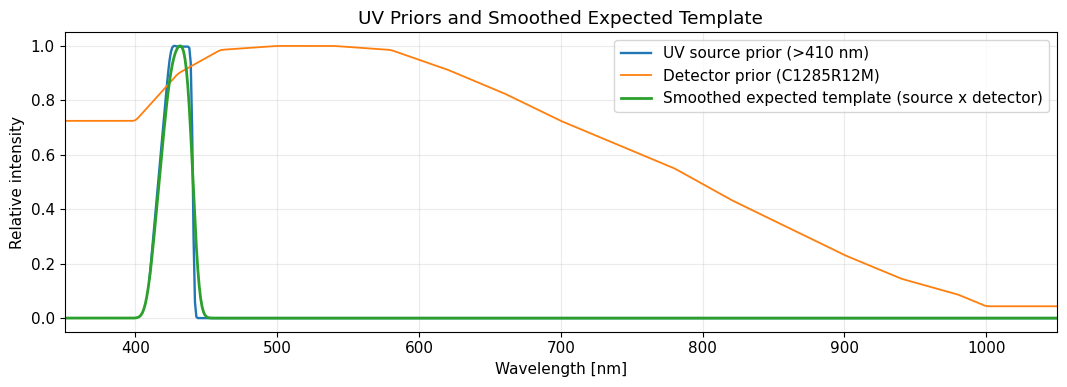

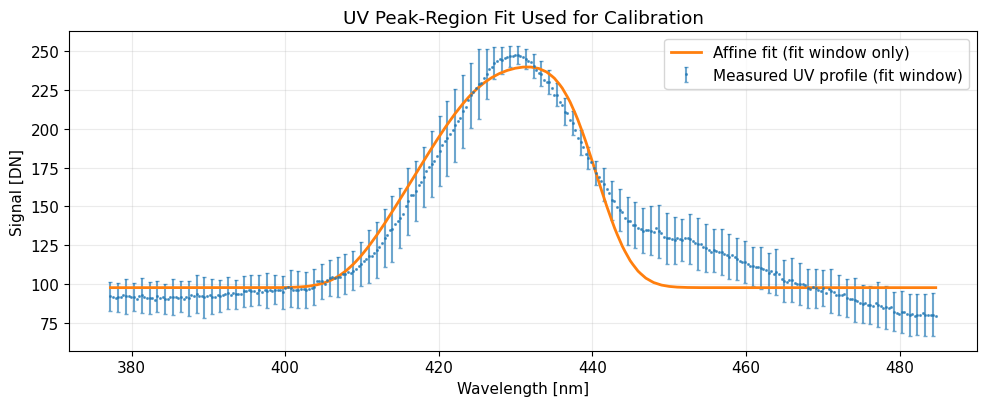

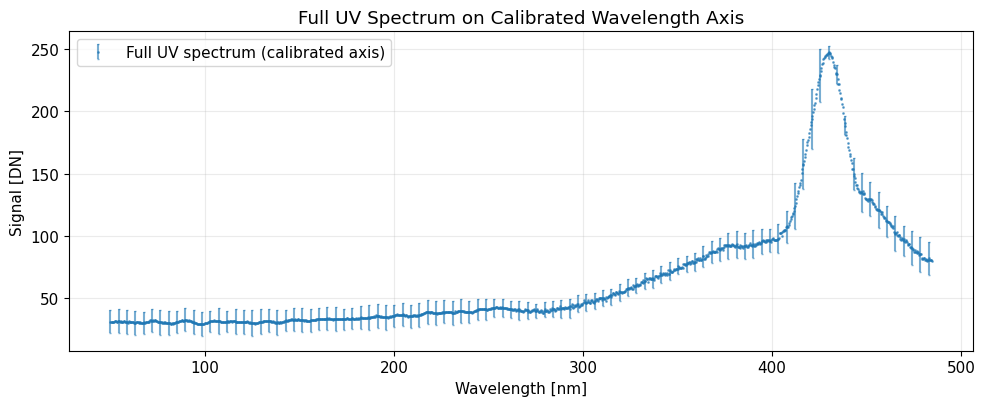

In [314]:

if ("uv", "corr") not in profiles:
    raise RuntimeError("UV dataset is not available in profiles; check SET_DIRS and UV folder contents.")

uv_profile_corr_mean, uv_profile_corr_sem, uv_per_frame_profiles = profiles[("uv", "corr")]

UV_SPECTRAL_CHART_URL = "https://www.labortechnik.com/sites/default/files/2023-08/uv_spectral_chart_e.pdf"
UV_BUMP_MIN_WL = 410.0
UV_FIT_FRAC_OF_PEAK = 0.35
UV_FIT_PAD_PX = 90
UV_FIT_MIN_WIDTH_PX = 260
UV_TEMPLATE_SMOOTH_SIGMA = 3.6


def digitize_uvl4_source_prior_from_uv_chart(pdf_url=UV_SPECTRAL_CHART_URL):
    """Digitize UVL-4-like curve from UV spectral chart PDF (UVP family chart)."""
    wl_fb = np.array([200, 205, 210, 215, 220, 240, 260, 280, 300, 310, 313, 320, 330, 340, 348, 355, 360, 365, 370, 380, 390, 404, 415, 430, 440], dtype=float)
    spd_fb = np.array([1.00, 1.00, 0.85, 0.15, 0.00, 0.00, 0.00, 0.00, 0.00, 0.02, 0.18, 0.06, 0.20, 0.62, 1.00, 0.95, 0.78, 0.62, 0.40, 0.20, 0.08, 0.16, 0.02, 0.00, 0.00], dtype=float)

    try:
        import fitz
        import requests
        raw = requests.get(pdf_url, timeout=45).content
        doc = fitz.open(stream=raw, filetype="pdf")
        pix = doc[0].get_pixmap(matrix=fitz.Matrix(2, 2), alpha=False)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)

        H, W = img.shape[:2]
        x0, x1 = int(0.080 * W), int(0.395 * W)
        y0, y1 = int(0.700 * H), int(0.927 * H)
        crop = img[y0:y1, x0:x1]
        ch, cw = crop.shape[:2]

        x_axis_left = int(0.037 * cw)
        x_axis_right = int(0.960 * cw)
        y_axis_bottom = int(0.910 * ch)

        R = crop[:, :, 0].astype(int)
        G = crop[:, :, 1].astype(int)
        B = crop[:, :, 2].astype(int)
        mask = (R < 170) & (G < 130) & (B < 190) & (B > 100) & ((B - G) > 15)

        x_use = np.arange(max(0, x_axis_left), min(cw, x_axis_right + 1), dtype=int)
        ys = np.full(x_use.size, np.nan, dtype=float)

        y_top_limit = max(0, int(0.06 * ch))
        y_bot_limit = min(ch, y_axis_bottom + 1)

        for j, xx in enumerate(x_use):
            yy = np.where(mask[y_top_limit:y_bot_limit, xx])[0]
            if yy.size:
                ys[j] = float(y_top_limit + np.min(yy))

        valid = np.isfinite(ys)
        if valid.sum() < 80:
            raise RuntimeError("Insufficient UV curve pixels detected")

        grid = np.arange(ys.size, dtype=float)
        ys = np.interp(grid, grid[valid], ys[valid])
        ys = gaussian_filter1d(ys, 1.1)

        wl = 200.0 + (x_use - x_axis_left) * (440.0 - 200.0) / max(x_axis_right - x_axis_left, 1)
        spd = np.clip(y_axis_bottom - ys, 0.0, None)
        spd = gaussian_filter1d(spd, 1.2)
        spd = spd / max(np.max(spd), 1e-12)

        return wl, spd, "UV spectral chart PDF digitized"
    except Exception:
        wl = np.arange(200.0, 441.0, 1.0)
        spd = np.interp(wl, wl_fb, spd_fb, left=0.0, right=0.0)
        spd = gaussian_filter1d(spd, 1.0)
        spd = spd / max(np.max(spd), 1e-12)
        return wl, spd, "UV fallback anchors"


uv_source_wl, uv_source_spd, uv_source_note = digitize_uvl4_source_prior_from_uv_chart()
uv_source_model_full = np.interp(wl_model, uv_source_wl, uv_source_spd, left=0.0, right=0.0)
uv_source_model_full = gaussian_filter1d(np.clip(uv_source_model_full, 0, None), 1.0)
uv_source_model_full = uv_source_model_full / max(np.max(uv_source_model_full), 1e-12)

# Use only right-hand bump for source prior shown/used in fit.
uv_source_model_fit = uv_source_model_full.copy()
uv_source_model_fit[wl_model < UV_BUMP_MIN_WL] = 0.0
uv_source_model_fit = uv_source_model_fit / max(np.max(uv_source_model_fit), 1e-12)

uv_template_fit = build_template(
    uv_source_model_fit,
    camera_resp_model,
    smooth_sigma=UV_TEMPLATE_SMOOTH_SIGMA,
)

uv_fit_window_idx, uv_fit_window_meta = select_peak_fit_window(
    uv_profile_corr_mean,
    frac_of_peak=UV_FIT_FRAC_OF_PEAK,
    pad_px=UV_FIT_PAD_PX,
    min_width_px=UV_FIT_MIN_WIDTH_PX,
)

uv_fit_nom = fit_affine_xy(
    uv_profile_corr_mean,
    uv_profile_corr_sem,
    uv_template_fit,
    fit_window_idx=uv_fit_window_idx,
)
if not uv_fit_nom["success"]:
    raise RuntimeError(f"UV fit failed: {uv_fit_nom['message']}")

uv_x_peak = uv_fit_nom["peak_x"]
uv_lambda_map_mean = uv_fit_nom["lambda"].copy()
uv_disp_nom = np.abs(np.gradient(uv_lambda_map_mean))

n_boot_uv = 120
uv_lambda_maps_boot = []
uv_slopes = []
uv_param_boot = []
for _ in range(n_boot_uv):
    idx = rng.integers(0, uv_per_frame_profiles.shape[0], size=uv_per_frame_profiles.shape[0])
    prof_b = uv_per_frame_profiles[idx].mean(axis=0)
    sem_b = robust_sigma(uv_per_frame_profiles[idx], axis=0) / np.sqrt(max(uv_per_frame_profiles.shape[0], 1))
    sem_b = regularize_sigma_vector(sem_b, prof_b)

    src_b = np.clip(uv_source_model_fit * (1.0 + gaussian_filter1d(rng.normal(0.0, 0.03, size=uv_source_model_fit.size), 2)), 0.0, None)
    src_b[wl_model < UV_BUMP_MIN_WL] = 0.0
    src_b = src_b / max(np.max(src_b), 1e-12)

    cam_b = np.clip(camera_resp_model * (1.0 + gaussian_filter1d(rng.normal(0.0, 0.02, size=camera_resp_model.size), 2)), 0.0, None)
    cam_b = cam_b / max(np.max(cam_b), 1e-12)

    tpl_b_fit = build_template(src_b, cam_b, smooth_sigma=UV_TEMPLATE_SMOOTH_SIGMA)

    fit_b = fit_affine_xy(prof_b, sem_b, tpl_b_fit, fit_window_idx=uv_fit_window_idx)
    if fit_b["success"]:
        uv_lambda_maps_boot.append(fit_b["lambda"])
        uv_slopes.append(fit_b["slope_nm_per_px"])
        uv_param_boot.append(fit_b["params"])

if len(uv_lambda_maps_boot) < 20:
    raise RuntimeError("Too few UV bootstrap fits for stable uncertainty estimates.")

uv_lambda_maps_boot = np.asarray(uv_lambda_maps_boot, dtype=float)
uv_param_boot = np.asarray(uv_param_boot, dtype=float)
uv_lambda_map_std = np.nanstd(uv_lambda_maps_boot, axis=0, ddof=1)
uv_disp_boot = np.abs(np.gradient(uv_lambda_maps_boot, axis=1))
uv_disp_std = uv_disp_boot.std(axis=0, ddof=1)

uv_lam_peak_template = float(uv_fit_nom["lambda_peak_template"])
uv_lam_peak_data = float(uv_fit_nom["lambda_peak_data"])
uv_lam0, uv_lamN = [float(v) for v in uv_fit_nom["lambda_edges"]]

x_offset, x_stretch, y_offset, y_stretch = [float(v) for v in uv_fit_nom["params"]]
ux_offset = float(np.std(uv_param_boot[:, 0], ddof=1)) if uv_param_boot.shape[0] > 1 else np.nan
ux_stretch = float(np.std(uv_param_boot[:, 1], ddof=1)) if uv_param_boot.shape[0] > 1 else np.nan
uy_offset = float(np.std(uv_param_boot[:, 2], ddof=1)) if uv_param_boot.shape[0] > 1 else np.nan
uy_stretch = float(np.std(uv_param_boot[:, 3], ddof=1)) if uv_param_boot.shape[0] > 1 else np.nan

print("UV calibration mode: full expected-template peak-region 4-parameter affine fit")
print(f"UV source note: {uv_source_note}")
print(f"Source prior used for fit: wavelength >= {UV_BUMP_MIN_WL:.1f} nm")
print("Fit template: full expected UV template from (source x detector), no mirroring.")
print(f"Expected-template smoothing sigma: {UV_TEMPLATE_SMOOTH_SIGMA:.2f} px-equivalent")
print("UV data preprocessing in pipeline: noisy-baseline smoothing for low x with blending.")
print(
    f"UV fit window (x px): {int(uv_fit_window_meta['x_left'])} to {int(uv_fit_window_meta['x_right'])} "
    f"(peak at {int(uv_fit_window_meta['x_peak'])})"
)
print(f"UV template peak wavelength: {uv_lam_peak_template:.2f} nm")
print(f"UV mapped data peak wavelength: {uv_lam_peak_data:.2f} nm")
print(f"UV edge wavelengths: x=0 -> {uv_lam0:.2f} nm, x=W-1 -> {uv_lamN:.2f} nm")
print(f"x_offset:  {x_offset:.4f} +/- {ux_offset:.4f} nm")
print(f"x_stretch: {x_stretch:.6f} +/- {ux_stretch:.6f} nm/pixel")
print(f"y_offset:  {y_offset:.4f} +/- {uy_offset:.4f} DN")
print(f"y_stretch: {y_stretch:.4f} +/- {uy_stretch:.4f} DN")

# Show source prior (>410 nm) and smoothed full expected template used in fit.
plt.figure(figsize=(10.8, 4.0))
mask_src = wl_model >= UV_BUMP_MIN_WL
plt.plot(wl_model[mask_src], uv_source_model_fit[mask_src], lw=1.7, label="UV source prior (>410 nm)")
plt.plot(wl_model, camera_resp_model, lw=1.3, label="Detector prior (C1285R12M)")
plt.plot(wl_model, uv_template_fit, lw=2.0, label="Smoothed expected template (source x detector)")
plt.xlim(350, 1050)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative intensity")
plt.title("UV Priors and Smoothed Expected Template")
plt.legend()
plt.tight_layout()

# Fit plot: only the region used for fitting.
fit_idx = uv_fit_nom["fit_window_idx"]
fit_lam = uv_lambda_map_mean[fit_idx]
fit_prof = uv_profile_corr_mean[fit_idx]
fit_sem = uv_profile_corr_sem[fit_idx]
fit_mod = uv_fit_nom["fit"][fit_idx]
ord_fit = np.argsort(fit_lam)

plt.figure(figsize=(10, 4.2))
plt.errorbar(
    fit_lam[ord_fit],
    fit_prof[ord_fit],
    yerr=fit_sem[ord_fit],
    fmt='.',
    ms=2.4,
    capsize=1.2,
    errorevery=max(1, len(fit_idx)//80),
    alpha=0.65,
    label="Measured UV profile (fit window)",
)
plt.plot(fit_lam[ord_fit], fit_mod[ord_fit], lw=2.0, label="Affine fit (fit window only)")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Signal [DN]")
plt.title("UV Peak-Region Fit Used for Calibration")
plt.legend()
plt.tight_layout()

# Full calibrated spectrum (data only) using wavelength axis derived from peak fit.
uv_ord = np.argsort(uv_lambda_map_mean)
uv_lam_sorted = uv_lambda_map_mean[uv_ord]
uv_prof_sorted = uv_profile_corr_mean[uv_ord]
uv_sem_sorted = uv_profile_corr_sem[uv_ord]

plt.figure(figsize=(10, 4.2))
plt.errorbar(
    uv_lam_sorted,
    uv_prof_sorted,
    yerr=uv_sem_sorted,
    fmt='.',
    ms=2.0,
    capsize=1.0,
    errorevery=max(1, len(xpix)//95),
    alpha=0.6,
    label="Full UV spectrum (calibrated axis)",
)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Signal [DN]")
plt.title("Full UV Spectrum on Calibrated Wavelength Axis")
plt.legend()
plt.tight_layout()


## 17) Pixel-Limited Spectral Resolution

Assuming pixel-limited resolution along the dispersion coordinate $y$,
we use the wavelength map from the UV peak fit to compute local dispersion:

$$
\frac{d\lambda}{dy}\;[\mathrm{nm/px}]
$$

With detector sampling width $\Delta y$ (pixel-limited case: $\Delta y = 1$ px),

$$
\Delta\lambda_{\mathrm{pixel}} = \left|\frac{d\lambda}{dy}\right|\,\Delta y
$$

and the resolving power is

$$
R_{\mathrm{pixel}} = \frac{\lambda_{\mathrm{peak}}}{\Delta\lambda_{\mathrm{pixel}}}.
$$

Uncertainties are estimated by bootstrap resampling of wavelength maps (fit uncertainty).


In [317]:

DELTA_Y_PX = 1.0  # pixel-limited resolution element along dispersion axis


def robust_median_dispersion(lambda_map, idx):
    lam = np.asarray(lambda_map, dtype=float)
    idx = np.asarray(idx, dtype=int)
    dlam_dy = np.abs(np.gradient(lam))
    vals = dlam_dy[idx]
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return np.nan
    return float(np.median(vals))


uv_fit_idx = np.asarray(uv_fit_nom["fit_window_idx"], dtype=int)
uv_peak_x = int(np.clip(np.round(uv_fit_nom["peak_x"]), 0, len(uv_lambda_map_mean) - 1))

uv_lambda_peak = float(uv_lambda_map_mean[uv_peak_x])
uv_disp_nm_per_px = robust_median_dispersion(uv_lambda_map_mean, uv_fit_idx)
uv_delta_lambda_pixel = float(uv_disp_nm_per_px * DELTA_Y_PX)
uv_R_pixel = float(uv_lambda_peak / max(uv_delta_lambda_pixel, 1e-12))

boot_peak = []
boot_disp = []
boot_dlam = []
boot_R = []
for lam_b in np.asarray(uv_lambda_maps_boot, dtype=float):
    disp_b = robust_median_dispersion(lam_b, uv_fit_idx)
    if not np.isfinite(disp_b):
        continue
    lam_peak_b = float(lam_b[uv_peak_x])
    dlam_b = float(disp_b * DELTA_Y_PX)
    R_b = float(lam_peak_b / max(dlam_b, 1e-12))

    if np.isfinite(R_b):
        boot_peak.append(lam_peak_b)
        boot_disp.append(disp_b)
        boot_dlam.append(dlam_b)
        boot_R.append(R_b)

boot_peak = np.asarray(boot_peak, dtype=float)
boot_disp = np.asarray(boot_disp, dtype=float)
boot_dlam = np.asarray(boot_dlam, dtype=float)
boot_R = np.asarray(boot_R, dtype=float)

summary = pd.DataFrame([
    {
        "set": "uv",
        "method": "Pixel-limited (delta_lambda = |d lambda/dy| * delta_y)",
        "delta_y_px": float(DELTA_Y_PX),
        "lambda_peak_nm": uv_lambda_peak,
        "u_lambda_peak_nm": float(np.std(boot_peak, ddof=1)) if boot_peak.size > 1 else np.nan,
        "dispersion_nm_per_px": uv_disp_nm_per_px,
        "u_dispersion_nm_per_px": float(np.std(boot_disp, ddof=1)) if boot_disp.size > 1 else np.nan,
        "delta_lambda_pixel_nm": uv_delta_lambda_pixel,
        "u_delta_lambda_pixel_nm": float(np.std(boot_dlam, ddof=1)) if boot_dlam.size > 1 else np.nan,
        "R_pixel": uv_R_pixel,
        "u_R_pixel": float(np.std(boot_R, ddof=1)) if boot_R.size > 1 else np.nan,
    }
])

print("UV resolving power summary (pixel-limited case):")
display(summary)


UV resolving power summary (pixel-limited case):


,set,method,delta_y_px,lambda_peak_nm,u_lambda_peak_nm,dispersion_nm_per_px,u_dispersion_nm_per_px,delta_lambda_pixel_nm,u_delta_lambda_pixel_nm,R_pixel,u_R_pixel
0,uv,Pixel-limited (delta_lambda = |d lambda/dy| * ...,1.0,429.96326,0.881021,0.340077,0.051234,0.340077,0.051234,1264.311581,285.760586


## 18) Diagnostics and Interpretation Notes

This section summarizes:

1. Exposure/saturation diagnostics
2. Dark-current and hot-pixel suppression from dark subtraction
3. UV calibration residual and wavelength-map uncertainty diagnostics



In [318]:
diag = pd.DataFrame([
    {
        "set": k,
        "saturated_frac_%": float((stacks_raw[k] >= 254).mean() * 100),
        "mean_DN": float(stacks_raw[k].mean()),
        "std_DN": float(stacks_raw[k].std()),
    }
    for k in ["dark", "laser", "ir", "uv"] if k in stacks_raw
])

print("Frame-level exposure diagnostics:")
display(diag)

print("Dark-current / hot-pixel suppression summary:")
display(dark_effect_df)

uv_fit_window_idx = uv_fit_nom["fit_window_idx"]
calib_diag = pd.DataFrame([
    {"metric": "Calibration mode", "value": "UV full-template peak-window 4-parameter affine fit", "units": "-"},
    {"metric": "UV source note", "value": uv_source_note, "units": "-"},
    {"metric": "UV fit window x_min", "value": int(uv_fit_window_idx[0]), "units": "px"},
    {"metric": "UV fit window x_max", "value": int(uv_fit_window_idx[-1]), "units": "px"},
    {"metric": "UV residual RMS (fit window)", "value": float(np.sqrt(np.mean((uv_profile_corr_mean[uv_fit_window_idx] - uv_fit_nom['fit'][uv_fit_window_idx]) ** 2))), "units": "DN"},
    {"metric": "UV residual RMS (full profile)", "value": float(uv_fit_nom['rms_full']), "units": "DN"},
    {"metric": "UV left-edge wavelength uncertainty", "value": float(np.std(uv_lambda_maps_boot[:, 0], ddof=1)), "units": "nm"},
    {"metric": "UV right-edge wavelength uncertainty", "value": float(np.std(uv_lambda_maps_boot[:, -1], ddof=1)), "units": "nm"},
    {"metric": "UV dispersion uncertainty", "value": float(np.std(np.abs(np.gradient(uv_lambda_maps_boot, axis=1)), ddof=1)), "units": "nm/px"},
])

print("UV wavelength-calibration diagnostic summary:")
display(calib_diag)


Frame-level exposure diagnostics:


,set,saturated_frac_%,mean_DN,std_DN
0,dark,0.000732,0.003160,0.824835
1,laser,92.253464,245.613897,38.959902
2,ir,1.804466,16.853039,45.364368
3,uv,0.892342,63.439166,51.596333


Dark-current / hot-pixel suppression summary:


,set,baseline_offset_raw_DN,baseline_offset_corr_DN,dark_current_offset_removed_DN,baseline_noise_raw_DN,baseline_noise_corr_DN,noise_reduction_DN,hot_pixel_mean_raw_DN,hot_pixel_mean_corr_DN,hot_pixel_suppression_DN
0,laser,255.00000,255.000000,0.000000,38.315472,38.323755,-0.008283,255.000000,96.057692,158.942308
1,ir,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,242.746154,83.803846,158.942308
2,uv,10.46712,11.632056,-1.164937,12.801387,12.251825,0.549562,161.830128,82.631911,79.198217


UV wavelength-calibration diagnostic summary:


,metric,value,units
0,Calibration mode,UV full-template peak-window 4-parameter affin...,-
1,UV source note,UV spectral chart PDF digitized,-
2,UV fit window x_min,963,px
3,UV fit window x_max,1279,px
4,UV residual RMS (fit window),13.027116,DN
5,UV residual RMS (full profile),50.37948,DN
6,UV left-edge wavelength uncertainty,56.859548,nm
7,UV right-edge wavelength uncertainty,8.708709,nm
8,UV dispersion uncertainty,0.051021,nm/px


## 19) References

Primary sources used in the UV calibration model:

1. C1285R12M quickview page (manufacturer spectral-response chart link):
   https://www.thorlabs.com/_QLPopup.cfm?PN=C1285R12M
2. C128xR12 sensor family page (manufacturer response-curve context):
   https://www.theimagingsource.com/en-us/product/sensor/1280-series/
3. UV spectral chart PDF used for UVL-4 source-shape prior digitization (365 nm BLB panel):
   https://www.labortechnik.com/sites/default/files/2023-08/uv_spectral_chart_e.pdf
4. Analytik Jena UVP UVL-4 product context (365 nm longwave handheld source):
   https://www.labmate-online.com/product/uv-lamps/3040/analytik-jena-us-llc/uvp-uv-lamps/15300

> Notebook update status: UV is the only wavelength-calibration/resolution path. IR is retained for image-level spot-property verification only.
